In [7]:
%matplotlib inline
import os
from time import sleep
#import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('default')
import numpy as np
import qcodes as qc
from qcodes import (
    Measurement,
    experiments,
    initialise_or_create_database_at,
    load_by_run_spec,
    load_or_create_experiment,
)
from qcodes.dataset.plotting import plot_dataset,plot_by_id
from qcodes.dataset.data_export import _get_data_from_ds
import scipy                    # http://scipy.org/
import scipy.optimize, scipy.special, scipy.stats
import cmath
import math
import resonator_tools
from resonator_tools import circuit
import lmfit
from scipy import interpolate,signal
from scipy.optimize import curve_fit
import pandas as pd
from scipy import constants
from matplotlib.colors import Normalize
from brokenaxes import brokenaxes

In [8]:
import importlib
import resonator_tools
importlib.reload(resonator_tools)

<module 'resonator_tools' from 'C:\\Users\\osagi\\AppData\\Local\\miniconda3\\envs\\qcodes\\Lib\\site-packages\\resonator_tools-0.1-py3.11.egg\\resonator_tools\\__init__.py'>

# Figure parameters

In [9]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim


In [10]:
columnwidth = 244 #revtex
textwidth = 510
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": 'serif',
#     "font.family": 'sans-serif',
#     "font.sans-serif":['Arial'],
    
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)
plt.rcParams['figure.figsize'] = set_size(columnwidth)

#   VNA Gate sweep

##  Fig.1e-f, Supplemen Fig1, Supp. Fig.8 - Gatemon RT 5nm 2

In [5]:
from resonator_tools import calibration
from resonator_tools import circuit

'L:/Oliver/Measurment/Resonator_measurement/20230810_10945_Gatemon_RT_5nm_2'

In [7]:
path = 'Gatemon_RT_5nm_2/20230810_10945_Gatemon_RT_5nm_2'

In [8]:
filename = 'Gatemon_RT_5nm_2/20230810_10945_Gatemon_RT_5nm_2/20230810_10945_Gatemon_RT_5nm_2.db'

In [9]:
initialise_or_create_database_at(filename)

In [10]:
dataset = load_by_run_spec(captured_run_id=26)

In [11]:
polar = dataset.get_parameter_data('VNA_tr1_polar')['VNA_tr1_polar']['VNA_tr1_polar']
freq = dataset.get_parameter_data('VNA_frequency_axis')['VNA_frequency_axis']['VNA_frequency_axis'][0]
gate = dataset.get_parameter_data('IVVI_dac10')['IVVI_dac10']['IVVI_dac10']

In [12]:
background = np.zeros(len(freq),dtype=complex)
background[0:450] = polar[0][0:450]
background[450:600] = polar[-1][450:600]
background[600:1001] = polar[0][600:1001]

In [13]:
port1= circuit.notch_port() 
port1.add_data(freq,background)

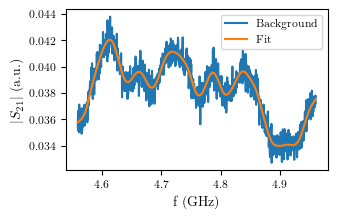

In [14]:
lam = 1e4#smoothness
p = 0.5  #asymmetry
fitted_baseline = port1.fit_baseline_amp(port1.z_data_raw,lam,p,niter=5000)
plt.plot(freq[0:1001]/1e9,np.absolute(port1.z_data_raw),label='Background')
plt.plot(freq[0:1001]/1e9,fitted_baseline,label='Fit')
plt.xlabel('f (GHz)')
plt.ylabel(r'$|S_{21}|$ (a.u.)')
plt.legend()

In [17]:
polar_corrected = []
for i in range(len(polar)):
    data = 20*np.log10(np.abs(polar[i])/fitted_baseline)
    polar_corrected.append(data)

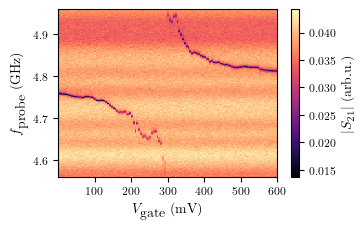

In [15]:
# Supplementary Fig.8 - for background correction

fig, ax = plt.subplots(figsize=set_size(textwidth,0.5))
plt.imshow(np.flipud(np.transpose(np.abs(polar[60:180]))),cmap='magma'
           ,interpolation ='none',interpolation_stage='rgba'
           ,extent =[gate[60], gate[180],freq[0]/1e9,freq[-1]/1e9],
           aspect='auto', vmin = np.min(np.abs(polar[60:180])), vmax = np.max(np.abs(polar[60:180])))
plt.ylabel(r'$f_{\textrm{probe}}$ (GHz)')
plt.xlabel(r'$V_{\textrm{gate}}$ (mV)')
plt.colorbar(label='$|S_{21}|$ (arb.u.)')

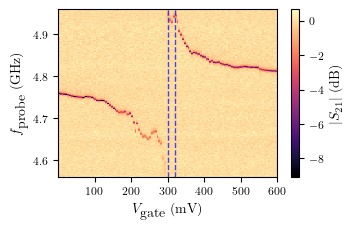

In [18]:
# Fig. 1e
fig, ax = plt.subplots(figsize=set_size(textwidth,0.5))

plt.imshow(np.flipud(np.transpose(polar_corrected[60:180])),cmap='magma'
           ,interpolation ='none',interpolation_stage='rgba'
           ,extent =[gate[60], gate[180],freq[0]/1e9,freq[-1]/1e9],
           aspect='auto', vmin = np.min(polar_corrected[60:180]), vmax = np.max(polar_corrected[60:180]))
plt.axvline(x=320, color='blue', linestyle='--', linewidth=1,alpha=0.7,label='')
plt.axvline(x=300, color='blue', linestyle='--', linewidth=1,alpha=0.7,label='')
plt.ylabel(r'$f_{\textrm{probe}}$ (GHz)')
plt.xlabel(r'$V_{\textrm{gate}}$ (mV)')
plt.colorbar(label='$|S_{21}|$ (dB)')


#plt.savefig(path+'\\id_26_new_dashedlines_noitalic.pdf',dpi=450,bbox_inches='tight')

In [22]:
dataset = load_by_run_spec(captured_run_id=43)
polar = dataset.get_parameter_data('VNA_tr1_polar')['VNA_tr1_polar']['VNA_tr1_polar']
freq = dataset.get_parameter_data('VNA_frequency_axis')['VNA_frequency_axis']['VNA_frequency_axis'][0]
gate = dataset.get_parameter_data('IVVI_dac10')['IVVI_dac10']['IVVI_dac10']

In [23]:
background = np.zeros(len(freq))
background[1700:3601] = np.abs(polar[0][1700:3601])
background[1500:1700] = np.abs(polar[-1][1500:1700])
background[0:1500] = np.abs(polar[0][0:1500])

In [24]:
port1= circuit.notch_port() 
port1.add_data(freq,background)

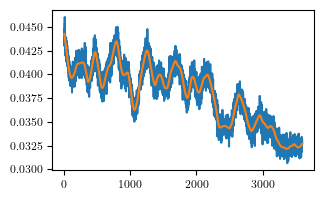

In [25]:
lam = 1e4#smoothness
p = 0.5  #asymmetry
fitted_baseline = port1.fit_baseline_amp(port1.z_data_raw,lam,p,niter=5000)
plt.plot(np.absolute(port1.z_data_raw))
plt.plot(fitted_baseline)

In [26]:
polar_corrected = []
for i in range(len(polar)):
    data = 20*np.log10(np.abs(polar[i])/fitted_baseline)
    window_size = 8
    rolling_avg = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    polar_corrected.append(rolling_avg)

NameError: name 'x_points' is not defined

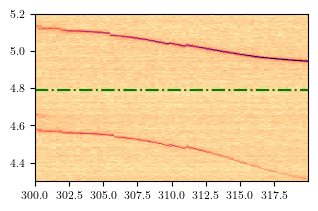

In [27]:
#Fig. 1f
fig, ax = plt.subplots(figsize=set_size(textwidth,0.5))


plt.imshow(np.flipud(np.transpose(polar_corrected[80:160])),cmap='magma'
           
           ,interpolation ='none',interpolation_stage='rgba'
           ,extent =[gate[80], gate[160],freq[0]/1e9,freq[-1]/1e9],
           aspect='auto', vmin = np.min(polar_corrected[80:160]), vmax = np.max(polar_corrected[80:160]))
plt.axhline(y=4.788, color='green', linestyle='-.', linewidth=1.5,label='Horizontal Line at y=0.5')
plt.plot(x_points, y_points, color='red', linewidth=1.5, linestyle='-.', label='Custom Line')
plt.text(311, 4.85, r'$f_{\textrm{c}}$', color='green', fontsize=10)
plt.text(315, 4.63, r'$f_{\textrm{q}} \left( V_{\textrm{g}} \right)$', color='red', fontsize=10)
plt.ylabel(r'$f_{\textrm{probe}}$ (GHz)')
plt.xlabel(r'$V_{\textrm{gate}}$ (mV)')
ax.spines['top'].set_color('blue')     # Top frame
ax.spines['bottom'].set_color('blue')  # Bottom frame
ax.spines['left'].set_color('blue')   # Left frame
ax.spines['right'].set_color('blue')  # Right frame

plt.colorbar(label='$|S_{21}|$ (dB)')
#plt.savefig(path+'\\id_43_blue_frame_noitalic.pdf',dpi=450,bbox_inches='tight')

Text(0, 0.5, '$|S_{21}|$ (dB)')

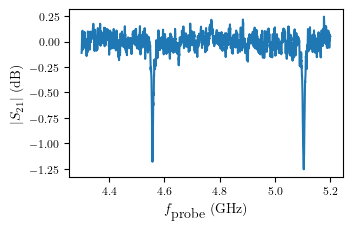

In [33]:
from scipy.signal import find_peaks
plt.figure(figsize=set_size(textwidth,0.5))
index = 91
peaks, _ = find_peaks(-polar_corrected[index],height = 0.3, distance = 1000)
plt.plot(freq[3:3597]/1e9,polar_corrected[index])
plt.xlabel(r'$f_{\textrm{probe}}$ (GHz)')
plt.ylabel('$|S_{21}|$ (dB)')
#plt.savefig(path+'\\id_43_91_new.pdf',dpi=200,bbox_inches='tight')


In [34]:
# Peak extraction
freqplus = []
freqminus = []
for i in range(80,160):
    peaks, _ = find_peaks(-polar_corrected[i],height = 0.3, distance = 1000)
    freqminus.append(freq[peaks[0]])
    freqplus.append(freq[peaks[1]])

    

Text(0.5, 0, '$f_{q}$ (GHz)')

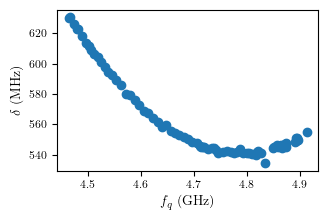

In [35]:
fc = 4.788e9
plt.scatter( (np.array(freqplus)+np.array(freqminus)-fc)/1e9, (np.array(freqplus)-np.array(freqminus))/1e6)
plt.ylabel(r'$\delta$ (MHz)')
plt.xlabel(r'$f_{q}$ (GHz)')

In [36]:
from scipy.optimize import curve_fit
def func(x, g ,fc):

    return np.sqrt((x*1e3-fc*1e3)**2+4*(g**2))

Text(0.5, 0, '$f_{\\textrm{q}}$ (GHz)')

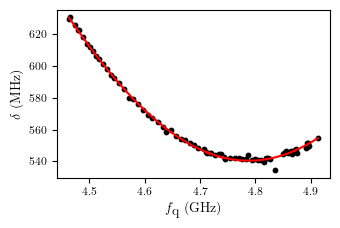

In [37]:
# Supplementary Fig. 8

plt.figure(figsize=set_size(textwidth,0.5))
f_q =(np.array(freqplus)+np.array(freqminus)-fc)/1e9
delta = (np.array(freqplus)-np.array(freqminus))/1e6
popt, pcov = curve_fit(func, f_q, delta,p0=[270,4.82])
plt.scatter(f_q,delta, color='black',s=10)
plt.plot(f_q, func(f_q, *popt),color='red')
plt.ylabel(r'$\delta$ (MHz)')
plt.xlabel(r'$f_{\textrm{q}}$ (GHz)')
#plt.savefig(path+'\\id_43_g.pdf',dpi=200,bbox_inches='tight')

Text(0, 0.5, '$f_{q}$ (GHz)')

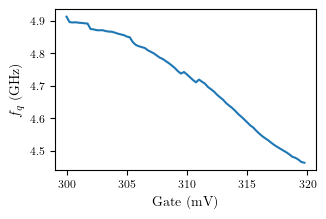

In [76]:
x_points = gate[80:160]
y_points = (np.array(freqplus)+np.array(freqminus)-fc)/1e9
plt.plot(gate[80:160],(np.array(freqplus)+np.array(freqminus)-fc)/1e9)
plt.xlabel('Gate (mV)')
plt.ylabel(r'$f_{q}$ (GHz)')

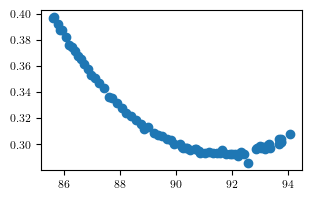

In [77]:
plt.figure()
plt.scatter(((np.array(freqplus)+np.array(freqminus))/1e9)**2, ((np.array(freqplus)-np.array(freqminus))/1e9)**2)


Supplementary Fig.1

In [45]:
filename = r'Gatemon_RT_5nm_2/20230810_10945_Gatemon_RT_5nm_2/20230810_10945_Gatemon_RT_5nm_2.db'
initialise_or_create_database_at(filename)
path = r'Gatemon_RT_5nm_2/20230810_10945_Gatemon_RT_5nm_2'

In [46]:
dataset = load_by_run_spec(captured_run_id=34)
polar = dataset.get_parameter_data('VNA_tr1_polar')['VNA_tr1_polar']['VNA_tr1_polar']
freq = dataset.get_parameter_data('VNA_frequency_axis')['VNA_frequency_axis']['VNA_frequency_axis'][0]
gate = dataset.get_parameter_data('IVVI_dac10')['IVVI_dac10']['IVVI_dac10']

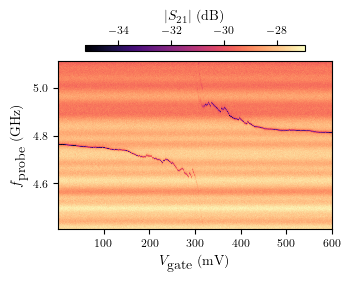

In [48]:
fig, ax = plt.subplots(figsize=set_size(textwidth,0.5))

plt.imshow(np.flipud(np.transpose(20*np.log10(np.abs(polar)))),cmap='magma'
           ,interpolation ='none',interpolation_stage='rgba'
           ,extent =[gate[0], gate[-1],freq[0]/1e9,freq[-1]/1e9],
           aspect='auto', vmin = np.min(20*np.log10(np.abs(polar))), vmax = np.max(20*np.log10(np.abs(polar))))
plt.ylabel(r'$f_{\textrm{probe}}$ (GHz)')
plt.xlabel(r'$V_{\textrm{gate}}$ (mV)')
cax = fig.add_axes([0.2, 0.925, 0.625, 0.03])  # Adjust the position as needed
norm = Normalize(vmin= np.min(20*np.log10(np.abs(polar))), vmax=np.max(20*np.log10(np.abs(polar))))
# Add a colorbar to the separate axis
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='magma'), cax=cax, orientation='horizontal', label='$|S_{21}|$ (dB)',location='top',shrink=0.75)
#plt.savefig(path+'\\id_43_broad_gate_range.pdf',dpi=450,bbox_inches='tight')

Quality factor extraction

In [49]:
dataset = load_by_run_spec(captured_run_id=26)
polar = dataset.get_parameter_data('VNA_tr1_polar')['VNA_tr1_polar']['VNA_tr1_polar']
freq = dataset.get_parameter_data('VNA_frequency_axis')['VNA_frequency_axis']['VNA_frequency_axis'][0]
gate = dataset.get_parameter_data('IVVI_dac10')['IVVI_dac10']['IVVI_dac10']

In [50]:
background = np.zeros(len(freq),dtype=complex)
background[0:450] = polar[0][0:450]
background[450:600] = polar[-1][450:600]
background[600:1001] = polar[0][600:1001]

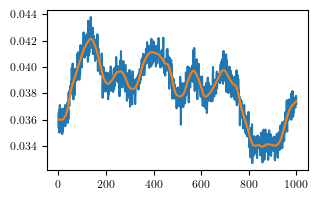

In [253]:
port1= circuit.notch_port() 
port1.add_data(freq,np.abs(background))
lam = 1e3#smoothness
p = 0.5  #asymmetry
fitted_baseline_amp = port1.fit_baseline_amp(port1.z_data_raw,lam,p,niter=5000)
plt.plot(np.absolute(port1.z_data_raw))
plt.plot(fitted_baseline_amp)

In [254]:
polar_corrected = []
for i in range(len(polar)):
    data_amp = np.abs(polar[i])/ fitted_baseline_amp
    polar_corrected.append(data_amp*np.exp(1j*np.angle(polar[i])))

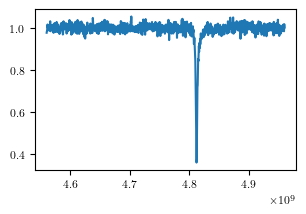

In [255]:
plt.plot(freq,np.abs(polar_corrected[-1]))

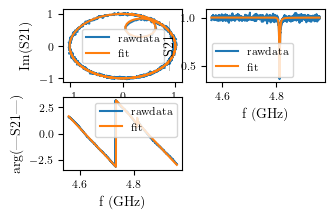

{'Qi_dia_corr': 3780.685447027747,
 'Qi_no_corr': 3790.8485096722143,
 'absQc': 2222.104965653893,
 'Qc_dia_corr': 2225.6119323245416,
 'Ql': 1400.9194203731033,
 'fr': 4812074247.475829,
 'theta0': -3.0854473891887615,
 'phi0': 0.056145265599522834,
 'phi0_err': 0.0430966846778621,
 'Ql_err': 94.05271452898222,
 'absQc_err': 96.12521405079018,
 'fr_err': 101198.99817846084,
 'chi_square': 0.0024285284710668267,
 'Qi_no_corr_err': 534.032299803372,
 'Qi_dia_corr_err': 529.645310713432}

In [256]:
port1 = circuit.notch_port()
    
port1.add_data(freq,polar_corrected[-1])
#port1.add_data(data[0][150:650],data_complex[150:650])
    
port1.autofit()
port1.plotall()
port1.fitresults

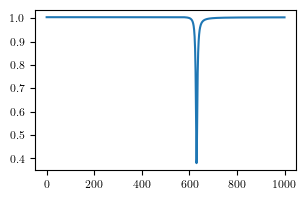

In [257]:
plt.plot(np.abs(port1.z_data_sim))

In [258]:
from scipy import signal

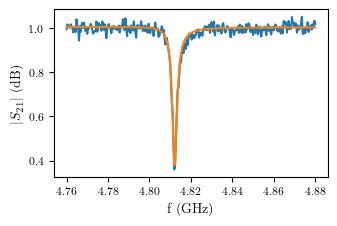

In [259]:
plt.figure(figsize=set_size(textwidth,0.5))
plt.plot(freq[500:801]/1e9,np.abs(polar_corrected[-1])[500:801])
plt.plot(freq[500:801]/1e9,np.abs(port1.z_data_sim)[500:801])
plt.xlabel('f (GHz)')
plt.ylabel('$|S_{21}|$ (dB)')
plt.savefig(path+'\\id_26_resonatorfit_amp.pdf',dpi=200,bbox_inches='tight')

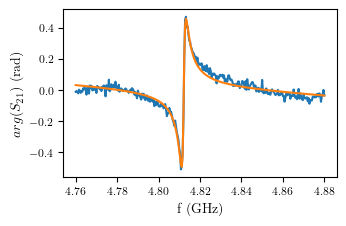

In [260]:
plt.figure(figsize=set_size(textwidth,0.5))
plt.plot(freq[500:801]/1e9,signal.detrend(np.angle(polar_corrected[-1])[500:801]))
plt.plot(freq[500:801]/1e9,signal.detrend(np.angle(port1.z_data_sim)[500:801]))
plt.xlabel('f (GHz)')
plt.ylabel('$arg (S_{21})$ (rad)')
plt.savefig(path+'\\id_26_resonatorfit_phase.pdf',dpi=200,bbox_inches='tight')

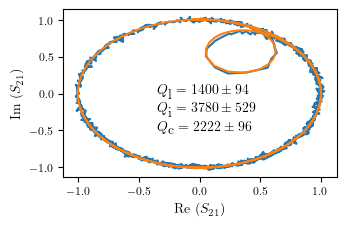

In [261]:
plt.figure(figsize=set_size(textwidth,0.5))
plt.plot(np.real(polar_corrected[-1]),np.imag(polar_corrected[-1]))
plt.plot(np.real(port1.z_data_sim),np.imag(port1.z_data_sim))
plt.xlabel('Re ($S_{21}$)')
plt.ylabel('Im ($S_{21}$)')
plt.text(-0.35, 0, r'$Q_{\textrm{l}} = 1400 \pm 94 $', color='black', fontsize=10)
plt.text(-0.35, -0.25, r'$Q_{\textrm{i}} = 3780 \pm 529 $', color='black', fontsize=10)
plt.text(-0.35, -0.5, r'$Q_{\textrm{c}} = 2222 \pm 96 $', color='black', fontsize=10)
plt.savefig(path+'\\id_26_complexfit_noitalic.pdf',dpi=200,bbox_inches='tight')

## Supplementary Fig.3  - Gatemon RT 5nm 1

In [52]:
path =r'Gatemon_RT_5nm_1/20221221_Gatemon_RT_5nm_1'
filename = r'Gatemon_RT_5nm_1/20221221_Gatemon_RT_5nm_1/20221221_Gatemon_RT_5nm_1.db'
initialise_or_create_database_at(filename)

In [53]:
dataset = load_by_run_spec(captured_run_id=14)
polar = dataset.get_parameter_data('VNA_tr1_polar')['VNA_tr1_polar']['VNA_tr1_polar']
freq = dataset.get_parameter_data('VNA_frequency_axis')['VNA_frequency_axis']['VNA_frequency_axis'][0]
gate = dataset.get_parameter_data('IVVI_dac6')['IVVI_dac6']['IVVI_dac6']

In [54]:
background = np.zeros(len(freq),dtype=complex)
background[500:901] = np.abs(polar[0][500:901])
background[300:500] = np.abs(polar[-300][300:500])
background[0:300] = np.abs(polar[0][0:300])

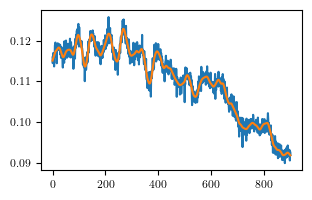

In [55]:
port1= circuit.notch_port() 
port1.add_data(freq,background)
lam = 1e2#smoothness
p = 0.5  #asymmetry
fitted_baseline = port1.fit_baseline_amp(port1.z_data_raw,lam,p,niter=5000)
plt.plot(np.absolute(port1.z_data_raw))
plt.plot(fitted_baseline)

In [56]:
polar_corrected = []
for i in range(len(polar)):
    data = 20*np.log10(np.abs(polar[i])/background)
    window_size = 4
    rolling_avg = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    polar_corrected.append(rolling_avg)


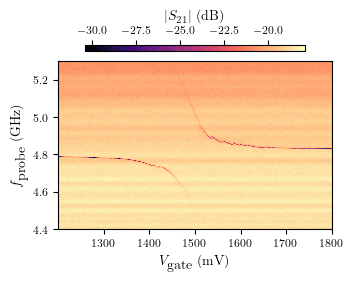

In [58]:
# Supplementary Fig.3 
fig, ax = plt.subplots(figsize=set_size(textwidth,0.5))
plt.imshow(np.flipud(np.transpose(20*np.log10(np.abs(polar)))),cmap='magma'
           ,interpolation ='none',interpolation_stage='rgba'
           ,extent =[gate[0], gate[-1],freq[0]/1e9,freq[-1]/1e9],
           aspect='auto', vmin = np.min(20*np.log10(np.abs(polar))), vmax = np.max(20*np.log10(np.abs(polar))))
plt.ylabel(r'$f_{\textrm{probe}}$ (GHz)')
plt.xlabel(r'$V_{\textrm{gate}}$ (mV)')
norm = Normalize(vmin=np.min(20*np.log10(np.abs(polar))), vmax=np.max(20*np.log10(np.abs(polar))))
cax = fig.add_axes([0.2, 0.925, 0.625, 0.03])  # Adjust the position as needed

# Add a colorbar to the separate axis
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='magma'), cax=cax, orientation='horizontal', label='$|S_{21}|$ (dB)',location='top',shrink=0.75)
#plt.savefig(path+'\\id_14_supplementary.pdf',dpi=450,bbox_inches='tight')

In [59]:
path = r'Gatemon_RT_5nm_1/20221220_Gatemon_RT_5nm_1'
filename = r'Gatemon_RT_5nm_1/20221220_Gatemon_RT_5nm_1/20221220_Gatemon_RT_5nm_1.db'
initialise_or_create_database_at(filename)

In [60]:
dataset = load_by_run_spec(captured_run_id=11)
polar = dataset.get_parameter_data('VNA_tr1_polar')['VNA_tr1_polar']['VNA_tr1_polar']
freq = dataset.get_parameter_data('VNA_frequency_axis')['VNA_frequency_axis']['VNA_frequency_axis'][0]
gate = dataset.get_parameter_data('IVVI_dac6')['IVVI_dac6']['IVVI_dac6']

In [61]:
background = np.zeros(len(freq))
background[400:901] = np.abs(polar[0][400:901])
background[300:400] = np.abs(polar[-1][300:400])
background[0:300] = np.abs(polar[0][0:300])

In [62]:
polar_corrected = []
for i in range(len(polar)):
    data = 20*np.log10(np.abs(polar[i])/background)
    window_size = 4
    rolling_avg = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    polar_corrected.append(rolling_avg)

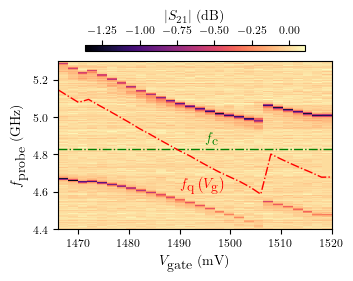

In [69]:
fig, ax = plt.subplots(figsize=set_size(textwidth,0.5))

ax.imshow(np.flipud(np.transpose(polar_corrected[8:36])),cmap='magma'
           
           ,interpolation ='none',interpolation_stage='rgba'
           ,extent =[gate[8], gate[-1],freq[0]/1e9,freq[-1]/1e9],
           aspect='auto', vmin = np.min(polar_corrected[8:36]), vmax = np.max(polar_corrected[8:36]))
plt.axhline(y=4.83, color='green', linewidth=1 ,linestyle='-.', label='Horizontal Line at y=0.5')
plt.plot(x_points, y_points, color='red', linewidth=1, linestyle='-.', label='Custom Line')
plt.text(1495, 4.87, r'$f_{\textrm{c}}$', color='green',  fontsize=10)
plt.text(1490, 4.62, r'$f_{\textrm{q}} \left( V_{\textrm{g}} \right)$', color='red', fontsize=10)
plt.ylabel(r'$f_{\textrm{probe}}$ (GHz)')
plt.xlabel(r'$V_{\textrm{gate}}$ (mV)')
norm = Normalize(vmin=np.min(polar_corrected[8:36]), vmax=np.max(polar_corrected[8:36]))
cax = fig.add_axes([0.2, 0.925, 0.625, 0.03])  # Adjust the position as needed

# Add a colorbar to the separate axis
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='magma'), cax=cax, orientation='horizontal', label='$|S_{21}|$ (dB)',location='top',shrink=0.75)

#plt.savefig(path+'\\id_11_supplementary_noitalic.pdf',dpi=450,bbox_inches='tight')

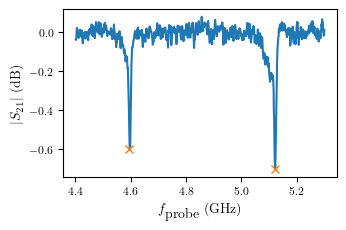

In [64]:
from scipy.signal import find_peaks
plt.figure(figsize=set_size(textwidth,0.5))
index = 17
peaks, _ = find_peaks(-polar_corrected[index],height = 0.15, distance = 100)
plt.plot(freq[2:900]/1e9,polar_corrected[index])
plt.xlabel(r'$f_{\textrm{probe}}$ (GHz)')
plt.ylabel('$|S_{21}|$ (dB)')
plt.plot(freq[peaks]/1e9, polar_corrected[index][peaks], "x")
#plt.savefig(path+'\\id_11_1484_supplementary.pdf',dpi=200,bbox_inches='tight')

Text(0.5, 0, '$f_{\\textrm{q}}$ (GHz)')

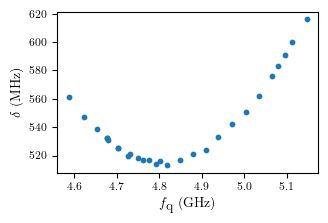

In [65]:
freqplus = []
freqminus = []
for i in range(8,36):
    peaks, _ = find_peaks(-polar_corrected[i],height = 0.15, distance = 100)
    freqminus.append(freq[peaks[0]])
    freqplus.append(freq[peaks[1]])
fc = 4.806e9
plt.scatter( (np.array(freqplus)+np.array(freqminus)-fc)/1e9, (np.array(freqplus)-np.array(freqminus))/1e6,s=10)
plt.ylabel(r'$\delta$ (MHz)')
plt.xlabel(r'$f_{\textrm{q}}$ (GHz)')

Text(0, 0.5, '$f_{q}$ (GHz)')

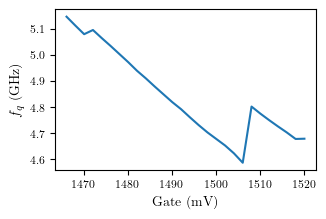

In [66]:
x_points = gate[8:36]
y_points = (np.array(freqplus)+np.array(freqminus)-fc)/1e9
plt.plot(gate[8:36],(np.array(freqplus)+np.array(freqminus)-fc)/1e9)
plt.xlabel('Gate (mV)')
plt.ylabel(r'$f_{q}$ (GHz)')

In [67]:
from scipy.optimize import curve_fit
def func(x, g ,fc):

    return np.sqrt((x*1e3-fc*1e3)**2+4*(g**2))

Text(0.5, 0, '$f_{\\textrm{q}}$ (GHz)')

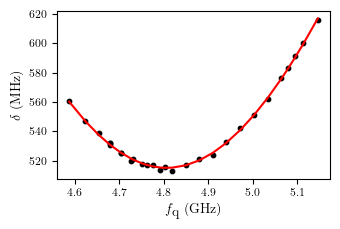

In [68]:
plt.figure(figsize=set_size(textwidth,0.5))
f_q =(np.array(freqplus)+np.array(freqminus)-fc)/1e9
delta = (np.array(freqplus)-np.array(freqminus))/1e6
popt, pcov = curve_fit(func, f_q, delta,p0=[270,4.82])
plt.scatter(f_q,delta, color='black',s=10)
plt.plot(np.sort(f_q), func(np.sort(f_q), *popt),color='red')
plt.ylabel(r'$\delta$ (MHz)')
plt.xlabel(r'$f_{\textrm{q}}$ (GHz)')
#plt.savefig(path+'\\id_11_g_supplementary.pdf',dpi=200,bbox_inches='tight')

# Supplementary Fig.4 - Gatemon RT_5nm_1- VNA Two tone

In [70]:
path = 'Gatemon_RT_5nm_1/20230103_Gatemon_RT_5nm_1'
filename = 'Gatemon_RT_5nm_1/20230103_Gatemon_RT_5nm_1/20230103_Gatemon_RT_5nm_1.db'

In [71]:
initialise_or_create_database_at(filename)

Qubit below the resonator

In [72]:
dataset = load_by_run_spec(captured_run_id=59)
data = _get_data_from_ds(dataset)
data =qc.dataset.plotting._complex_to_real_preparser(data,conversion='mag_and_phase')
freq = data[0][0]['data'].flatten()
gate = data[0][1]['data'].flatten()
polar_abs = data[0][2]['data'].flatten()
polar_phase = data[1][2]['data'].flatten()
data_reshaped =qc.dataset.data_export.reshape_2D_data(freq,gate,polar_abs)
data_reshaped_2 =qc.dataset.data_export.reshape_2D_data(freq,gate,polar_phase)

Trying to mark a run completed that was already completed.


In [73]:
for i in range(len(data_reshaped[2])):
    data_reshaped[2][i] = data_reshaped[2][i] - np.mean(data_reshaped[2][i])
    data_reshaped_2[2][i] = data_reshaped_2[2][i] - np.mean(data_reshaped_2[2][i])

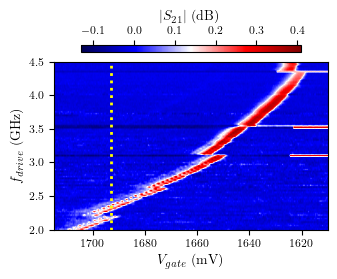

In [74]:
fig, ax = plt.subplots(figsize=set_size(textwidth,0.5))
ax.imshow(20*np.log10(data_reshaped[2]+1),cmap='seismic'
           ,interpolation ='bilinear',interpolation_stage='data',alpha=1
           ,extent =[gate[0], gate[-1],min(freq)/1e9,max(freq)/1e9],
           aspect='auto', vmin = np.min(20*np.log10(np.flipud(data_reshaped[2]+1))), 
            vmax = np.max(20*np.log10(np.flipud(data_reshaped[2]+1))),
                                        resample=True)
plt.xlabel('$V_{gate}$ (mV)')
plt.axvline(x=1693, color='yellow', linestyle=':', linewidth=2,alpha=1,label='')
plt.ylabel('$f_{drive}$ (GHz)')
norm = Normalize(vmin=np.min(20*np.log10(np.flipud(data_reshaped[2]+1))), vmax=np.max(20*np.log10(np.flipud(data_reshaped[2]+1))))
cax = fig.add_axes([0.2, 0.925, 0.625, 0.03])  # Adjust the position as needed

# Add a colorbar to the separate axis
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='seismic'), cax=cax, orientation='horizontal', label='$|S_{21}|$ (dB)',location='top',shrink=0.75)
#plt.savefig(path+'\\id_59_supplementary_withdashedline.pdf',dpi=450,bbox_inches='tight')

In [75]:
freq_data =data_reshaped[0]/1e9

#Linecut

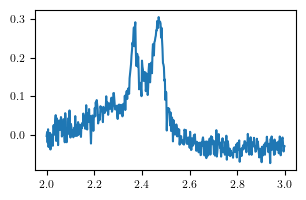

In [76]:
index=-11
begin=0
end=500
plt.plot(data_reshaped[0][0:500]/1e9,20*np.log10(data_reshaped[2]+1)[index][0:500])

In [77]:
gate = data_reshaped[1]
gate[-20]

1693.99804496579

In [78]:
index=-20
begin=100
end=700
fit_data = data_reshaped[2][index][begin:end]
freq_data = data_reshaped[0][begin:end]/1e9
freq_guess =freq_data[np.argmax(fit_data)]
peak1 = lmfit.models.LorentzianModel(prefix='l1_')
peak2 = lmfit.models.LorentzianModel(prefix='l2_')
background = lmfit.models.LinearModel()
model = background + peak1 + peak2
model.param_names
params = model.make_params(slope=1e-7,intercept=np.min(fit_data),l1_amplitude=np.max(fit_data),l1_center=freq_guess,
                           l1_sigma=0.05,l2_amplitude=np.max(fit_data),l2_center=freq_guess-0.05,l2_sigma=0.1)
result = model.fit(fit_data, params, x=freq_data)

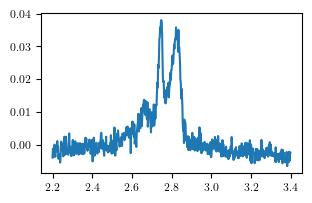

In [79]:
plt.plot(freq_data,fit_data)

([], [])

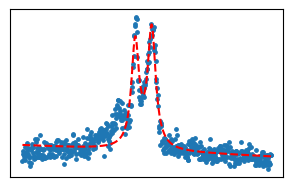

In [80]:
plt.figure(figsize=set_size(textwidth,0.5))
plt.scatter(data_reshaped[0][begin:end]/1e9,data_reshaped[2][index][begin:end],s=6)
plt.plot(data_reshaped[0][begin:end]/1e9,result.best_fit,'r--',linewidth=1.5)
#plt.xlabel(r'$f_{d}$ (GHz)')
#plt.ylabel('$|S_{21}|$ (a.u.)')
plt.xticks([])  
 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
#plt.savefig(path+'\\id_59_gate1693.pdf',dpi=200,bbox_inches='tight')

Qubit above the resonator

In [81]:
dataset = load_by_run_spec(captured_run_id=89)
data = _get_data_from_ds(dataset)
data =qc.dataset.plotting._complex_to_real_preparser(data,conversion='mag_and_phase')
freq = data[0][0]['data'].flatten()
gate = data[0][1]['data'].flatten()
polar_abs = data[0][2]['data'].flatten()
polar_phase = data[1][2]['data'].flatten()
data_reshaped =qc.dataset.data_export.reshape_2D_data(freq,gate,polar_abs)
data_reshaped_2 =qc.dataset.data_export.reshape_2D_data(freq,gate,polar_phase)

Trying to mark a run completed that was already completed.


In [82]:
for i in range(len(data_reshaped[2])):
    data_reshaped[2][i] = data_reshaped[2][i] - np.mean(data_reshaped[2][i])
    data_reshaped_2[2][i] = data_reshaped_2[2][i] - np.mean(data_reshaped_2[2][i])

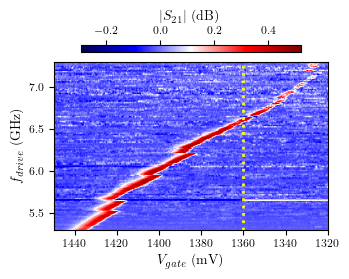

In [83]:
fig, ax = plt.subplots(figsize=set_size(textwidth,0.5))
ax.imshow(20*np.log10(data_reshaped[2]+1),cmap='seismic'
           ,interpolation ='bilinear',interpolation_stage='data',alpha=1
           ,extent =[gate[-1], gate[0],min(freq)/1e9,max(freq)/1e9],
           aspect='auto', vmin = np.min(20*np.log10(np.flipud(data_reshaped[2]+1))), 
            vmax = np.max(20*np.log10(np.flipud(data_reshaped[2]+1))),
                                        resample=True)
plt.axvline(x=1360, color='yellow', linestyle=':', linewidth=2,alpha=1,label='')
plt.xlabel('$V_{gate}$ (mV)')
plt.ylabel('$f_{drive}$ (GHz)')
norm = Normalize(vmin=np.min(20*np.log10(np.flipud(data_reshaped[2]+1))), vmax=np.max(20*np.log10(np.flipud(data_reshaped[2]+1))))
cax = fig.add_axes([0.2, 0.925, 0.625, 0.03])  # Adjust the position as needed

# Add a colorbar to the separate axis
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='seismic'), cax=cax, orientation='horizontal', label='$|S_{21}|$ (dB)',location='top',shrink=0.75)
#plt.savefig(path+'\\id_89_supplementary.pdf',dpi=450,bbox_inches='tight')

In [84]:
index=40
begin=600
end=901
fit_data = data_reshaped[2][index][begin:end]
freq_data = data_reshaped[0][begin:end]/1e9
freq_guess =freq_data[np.argmax(fit_data)]
peak1 = lmfit.models.LorentzianModel(prefix='l1_')
peak2 = lmfit.models.LorentzianModel(prefix='l2_')
background = lmfit.models.LinearModel()
model = background + peak1 + peak2
model.param_names
params = model.make_params(slope=1e-6,intercept=np.min(fit_data),l1_amplitude=np.max(fit_data),l1_center=freq_guess,
                           l1_sigma=0.05,l2_amplitude=np.max(fit_data),l2_center=freq_guess-0.05,l2_sigma=0.05)
result = model.fit(fit_data, params, x=freq_data)

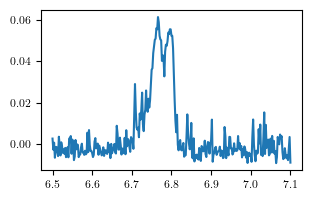

In [85]:
plt.plot(freq_data,fit_data)

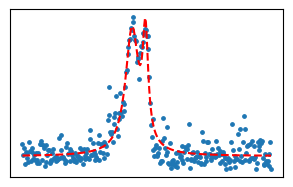

In [146]:
plt.figure(figsize=set_size(textwidth,0.5))
plt.scatter(data_reshaped[0][begin:end]/1e9,data_reshaped[2][index][begin:end],s=6)
plt.plot(data_reshaped[0][begin:end]/1e9,result.best_fit,'r--',linewidth=1.5)
#plt.xlabel(r'$f_{d}$ (GHz)')
#plt.ylabel('$|S_{21}|$ (a.u.)')
plt.xticks([])  
 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
#
#plt.savefig(path+'\\id_89_gate1693.pdf',dpi=200,bbox_inches='tight')

## Qfreq and aharmonicity


In [88]:
gate_array,qubit_freq,anharmonicity = np.loadtxt("Gatemon_RT_5nm_1\\20230103_Gatemon_RT_5nm_1\\id_59and89_gate_qubitfreq_anharmoncity.txt",
                                                unpack=True)

Text(0.5, 0, '$V_{gate}$ (mV)')

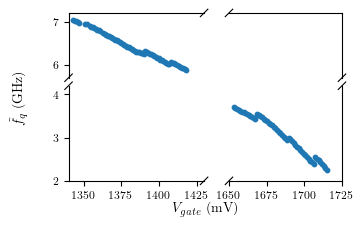

In [89]:
from brokenaxes import brokenaxes
plt.figure(figsize=set_size(textwidth,0.5))
baxes = brokenaxes(xlims=((1340,1430),(1650,1725)), ylims=((2,4.2),(5.7,7.2)), hspace=.1, despine=False)

baxes.scatter(gate_array[:57],np.array(qubit_freq[:57]),s=10,color='#1f77b4')
baxes.scatter(gate_array[57:],np.array(qubit_freq[57:]),s=10,color='#1f77b4')


baxes.set_ylabel(r'$\tilde{f_{q}}$ (GHz)')
baxes.set_xlabel('$V_{gate}$ (mV)')
#plt.savefig(path+'\\qubit_freq_supplementary.pdf',dpi=450,bbox_inches='tight')

Text(0.5, 0, '$V_{gate}$ (mV)')

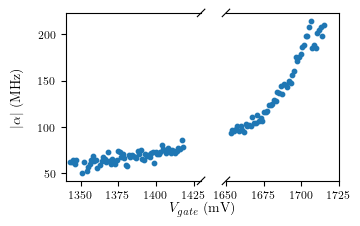

In [90]:
plt.figure(figsize=set_size(textwidth,0.5))
baxes = brokenaxes(xlims=((1340,1430),(1650,1725)), hspace=.1,despine=False)

baxes.scatter(gate_array[:57],2*1000*np.array(anharmonicity[:57]),s=10,color='#1f77b4')

baxes.scatter(gate_array[57:],2*1000*np.array(anharmonicity[57:]),s=10,color='#1f77b4')

baxes.set_ylabel((r'$|\alpha|$ (MHz)'))
baxes.set_xlabel('$V_{gate}$ (mV)')
#plt.savefig(path+'\\anharmonicity_supplementary.pdf',dpi=450,bbox_inches='tight')


# Fig.2. - OPX two-tone gatesweep


Two tone, qubit below the resonator

In [19]:
from scipy.signal import find_peaks

def fit_double_Lorentzian(xdata,ydata,peak_thrs):
    peak1 = lmfit.models.LorentzianModel(prefix='l1_')
    peak2 = lmfit.models.LorentzianModel(prefix='l2_')
    background = lmfit.models.LinearModel()
    
    step = np.abs(xdata[0]-xdata[-1])/len(xdata)
    peaks, prop = find_peaks(ydata,height = peak_thrs,distance=int(25e6/step),width=int(8e6/step))
    widths = prop['widths']
    
    model1 = background + peak1 +peak2
    model2 = background + peak1

    if len(widths) == 1:
        amp_l1 = phi_normalized[i][peaks[0]]
        freq_l1 = freq[i][peaks[0]]/1e9
        width_l1 = widths[0]*step/1e9
        
        params = model2.make_params(slope=0,intercept=np.min(phi_normalized[i]),
                               l1_amplitude=amp_l1*np.pi*width_l1,
                               l1_center=freq_l1,l1_sigma=width_l1)
        result = model2.fit(phi_normalized[i], params, x=freq[i]/1e9)

        
    else:
        amp_l2 = phi_normalized[i][peaks[0]]
        amp_l1 = phi_normalized[i][peaks[1]]
        freq_l1 = freq[i][peaks[1]]/1e9
        freq_l2 = freq[i][peaks[0]]/1e9
        width_l1 = widths[1]*step/1e9
        width_l2 = widths[0]*step/1e9
        
        params = model1.make_params(slope=0,intercept=np.min(phi_normalized[i]),
                               l1_amplitude=amp_l1*np.pi*width_l1,
                               l1_center=freq_l1,l1_sigma=width_l1,
                               l2_amplitude=amp_l2*np.pi*width_l2,
                               l2_center=freq_l2,l2_sigma=width_l2)
        
        result = model1.fit(phi_normalized[i], params, x=freq[i]/1e9)
    

    
    return [result.best_values,np.diagonal(result.covar)]


In [20]:
filename = 'Gatemon_RT_5nm_2/20230905_Gatemon_RT_5nm_2/20230905_Gatemon_RT_5nm_2.db'
path='Gatemon_RT_5nm_2/20230905_Gatemon_RT_5nm_2'
initialise_or_create_database_at(filename);

In [21]:
dataset = load_by_run_spec(captured_run_id=20) #freq setpoint is different for each gate voltage
data = _get_data_from_ds(dataset)

gate = data[0][0]['data']
freq  = data[0][1]['data']

phi = data[3][2]['data'] -np.mean(data[3][2]['data'],axis=1)[:,np.newaxis]
row_magnitudes = np.linalg.norm(phi, axis=1, keepdims=True)
phi_normalized = phi / row_magnitudes
R = data[2][2]['data'] -np.mean(data[2][2]['data'],axis=1)[:,np.newaxis]

Trying to mark a run completed that was already completed.


In [22]:
gatemin = np.min(gate)
gatemax = np.max(gate)
dg = gate[:,0][1]-gate[:,0][0]
gatelen = int(np.abs((gatemax-gatemin)/dg)+1)
gates = np.arange(gatemax,gatemin+dg,dg)
df = freq[0][1]-freq[0][0]
fmin = np.min(freq)
fmax = np.max(freq)
flen = int((fmax-fmin)/df +1)
freqs = np.arange(fmin,fmax+df,df)
phi_new = np.full((gatelen,flen),np.NaN)
sorter = np.argsort(freqs)
for i in range(len(gate)):
    
    indexes = sorter[np.searchsorted(freqs, freq[i], sorter=sorter)]
    for count,element in enumerate(indexes):
        phi_new[i][element] = phi_normalized[i][count]
    

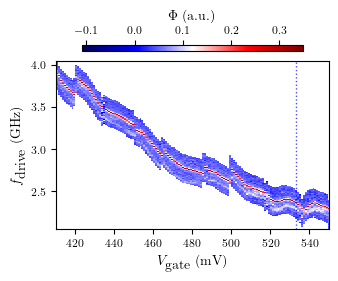

In [23]:
fig, ax = plt.subplots(figsize=set_size(textwidth,0.5))
ax.imshow(np.flipud(np.transpose(np.flip(phi_new,0))),cmap='seismic'
           ,interpolation ='none',interpolation_stage='data',alpha=1
           ,extent =[gate[:,0][-1], gate[:,0][0],min(freqs)/1e9,max(freqs)/1e9],
           aspect='auto', vmin = np.min(phi_normalized), vmax = np.max(phi_normalized),resample=True)
plt.xlabel(r'$V_{\textrm{gate}}$ (mV)')
plt.ylabel(r'$f_{\textrm{drive}}$ (GHz)')
plt.axvline(x=533, color='blue', linestyle=':', linewidth=1,alpha=0.7,label='')
norm = Normalize(vmin=np.min(phi_normalized[0:81]), vmax=np.max(phi_normalized[0:81]))
cax = fig.add_axes([0.2, 0.925, 0.625, 0.03])  # Adjust the position as needed

# Add a colorbar to the separate axis
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='seismic'), cax=cax, orientation='horizontal', label=r'$\Phi$ (a.u.)',location='top',shrink=0.75)

#plt.savefig(path+'\\id_20_paper_cbarabove_nointerp.pdf',dpi=450,bbox_inches='tight')

In [25]:
fit_results = []
for i in range(len(phi_normalized)):
    fit_results.append(fit_double_Lorentzian(freq[i],phi_normalized[i],0.01))
    

In [26]:
qfreq1 = []
qfreq2 = []
amp1 = []
amp2 = []
for i in range(len(fit_results)):
    qfreq2.append(fit_results[i][0]['l1_center'])
    amp2.append(fit_results[i][0]['l1_amplitude']/fit_results[i][0]['l1_sigma'])
    if 'l2_center' in  fit_results[i][0]: 
        qfreq1.append(fit_results[i][0]['l2_center'])      
        amp1.append(fit_results[i][0]['l2_amplitude']/fit_results[i][0]['l2_sigma'])
    else:
        qfreq1.append(np.nan)
        amp1.append(np.nan)

0.006440515349376574

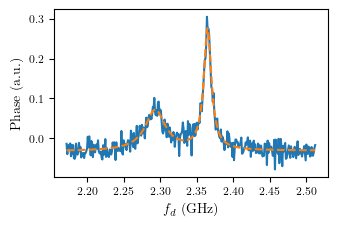

In [25]:
i =17
fig, ax = plt.subplots(figsize=set_size(textwidth,0.5))

freq_guess =freq[i][np.argmax(phi[i])]/1e9
peak1 = lmfit.models.LorentzianModel(prefix='l1_')
peak2 = lmfit.models.LorentzianModel(prefix='l2_')
background = lmfit.models.LinearModel()
model = background + peak1 +peak2
model.param_names
step = np.abs(freq[i][0]-freq[i][-1])/len(freq[i])
peaks, prop = find_peaks(phi_normalized[i],height = 0.02,distance=int(25e6/step),width=int(8e6/step))
widths = prop['widths']

if len(widths) == 1:
    amp_l1 = phi_normalized[i][peaks[0]]
    amp_l2 = amp_l1/3
    freq_l1 = freq[i][peaks[0]]/1e9
    freq_l2 = freq_l1-0.07
    width_l1 = widths[0]*step/1e9
    width_l2 = 2*width_l1
else:
    amp_l2 = phi_normalized[i][peaks[0]]
    amp_l1 = phi_normalized[i][peaks[1]]
    freq_l1 = freq[i][peaks[1]]/1e9
    freq_l2 = freq[i][peaks[0]]/1e9
    width_l1 = widths[1]*step/1e9
    width_l2 = widths[0]*step/1e9

params = model.make_params(slope=0,intercept=np.min(phi_normalized[i]),
                           l1_amplitude=amp_l1*np.pi*width_l1,
                           l1_center=freq_l1,l1_sigma=width_l1,
                           l2_amplitude=amp_l2*np.pi*width_l2,
                           l2_center=freq_l2,l2_sigma=width_l2)
result = model.fit(phi_normalized[i], params, x=freq[i]/1e9)

plt.plot(freq[i]/1e9,phi_normalized[i])
plt.plot(freq[i]/1e9,result.best_fit,'--')
#plt.xticks([])  
 
# disabling yticks by setting yticks to an empty list
#plt.yticks([])  
plt.xlabel('$f_{d}$ (GHz)')
plt.ylabel('Phase (a.u.)')
plt.savefig(path+'\\inset_paper_2_with_ticks.pdf',dpi=450,bbox_inches='tight')
#lt.plot(freq[i][peaks]/1e9, phi_normalized[i][peaks], "x")
phi_normalized[i][peaks[0]]*np.pi*width_l2
#plt.plot(freq/1e9,polar_corrected[index])

In [48]:
from matplotlib.patches import Rectangle
from copy import copy

In [116]:
data = np.loadtxt("Gatemon_RT_5nm_2\\20230908_Gatemon_RT_5nm_2\\qubit_freq_merged.txt")

Text(0, 0.5, '')

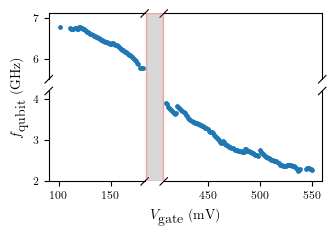

In [117]:

gate=data[0]
qfreq = data[1]

baxes = brokenaxes(xlims=((90,182),(408,560)), ylims=((2,4.2),(5.5,7.1)), hspace=.15, wspace=0.15,despine=False,fig=plt.figure(figsize=set_size(textwidth,0.5)))

baxes.scatter(gate,qfreq,color='#1f77b4',s=6)
newax = baxes.fig.add_axes((0,0,0.5,0.5), frameon=False)


newax.set_position([0.125,0.10999,0.9-0.125,0.88-0.10999])

newax.add_patch(Rectangle((0.354, 0), 0.065, 1,alpha=0.3,facecolor='gray',edgecolor='red',lw=1,antialiased=True))

newax.set_xticks([])
newax.set_yticks([]) 

baxes.set_ylabel(r'$f_{\textrm{qubit}}$ (GHz)',labelpad=15)
baxes.set_xlabel(r'$V_{\textrm{gate}}$ (mV)',labelpad=20)
#plt.text(0.3657,.2, 'Resonant regime', color='black', fontsize=10,rotation='vertical')
# baxes.axs[0].set_xticks([])
# baxes.axs[1].set_xticks([])
# baxes.axs[2].set_xticks([])
# baxes.axs[3].set_xticks([])

baxes.axs[0].set_visible(True)

newax.set_xlabel('')
newax.set_ylabel('')
#plt.savefig(path+'\\qubitfreq_brokenaxes_paper_grayshade.pdf',dpi=200,bbox_inches='tight')

Qubit above the resonator

In [35]:
path = 'Gatemon_RT_5nm_2/20230908_Gatemon_RT_5nm_2'
filename='Gatemon_RT_5nm_2/20230908_Gatemon_RT_5nm_2/20230908_Gatemon_RT_5nm_2.db'
initialise_or_create_database_at(filename);

In [36]:
dataset = load_by_run_spec(captured_run_id=36) #freq setpoint is different for each gate voltage
data = _get_data_from_ds(dataset)

gate = data[0][0]['data']
freq  = data[0][1]['data']

phi = data[3][2]['data'] -np.mean(data[3][2]['data'],axis=1)[:,np.newaxis]
row_magnitudes = np.linalg.norm(phi, axis=1, keepdims=True)
phi_normalized = phi / row_magnitudes
R = data[2][2]['data'] -np.mean(data[2][2]['data'],axis=1)[:,np.newaxis]

Trying to mark a run completed that was already completed.


In [37]:
gatemin = np.min(gate)
gatemax = np.max(gate)
dg = gate[:,0][1]-gate[:,0][0]
gatelen = int(np.abs((gatemax-gatemin)/dg)+1)
gates = np.arange(gatemax,gatemin+dg,dg)
df = freq[0][1]-freq[0][0]
fmin = np.min(freq)
fmax = np.max(freq)
flen = int((fmax-fmin)/df +1)
freqs = np.arange(fmin,fmax+df,df)

In [38]:
phi_new = np.full((gatelen,flen),np.NaN)

In [39]:
sorter = np.argsort(freqs)
for i in range(len(gate)):
    
    indexes = sorter[np.searchsorted(freqs, freq[i], sorter=sorter)]
    for count,element in enumerate(indexes):
        phi_new[i][element] = phi_normalized[i][count]
    

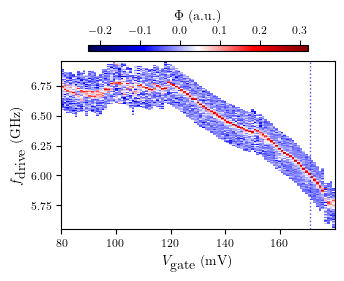

In [40]:

fig, ax = plt.subplots(figsize=set_size(textwidth,0.5))

ax.imshow(np.flipud(np.transpose(np.flip(phi_new,0))),cmap='seismic'
           ,interpolation ='none',interpolation_stage='data',alpha=1
           ,extent =[gate[:,0][-1], gate[:,0][0],min(freqs)/1e9,max(freqs)/1e9],
           aspect='auto', vmin = np.min(phi_normalized), vmax = np.max(phi_normalized),resample=True)
plt.axvline(x=171, color='blue', linestyle=':', linewidth=1,alpha=0.7,label='')
plt.xlabel(r'$V_{\textrm{gate}}$ (mV)')
plt.ylabel(r'$f_{\textrm{drive}}$ (GHz)')

norm = Normalize(vmin=np.min(phi_normalized), vmax=np.max(phi_normalized))
cax = fig.add_axes([0.2, 0.925, 0.625, 0.03])  # Adjust the position as needed

# Add a colorbar to the separate axis
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='seismic'), cax=cax, orientation='horizontal', label=r'$\Phi$ (a.u.)',location='top',shrink=0.75)

#plt.savefig(path+'\\id_36_paper_cbar_above_nointerp.pdf',dpi=450,bbox_inches='tight')

Text(0, 0.5, 'Phase (a.u.)')

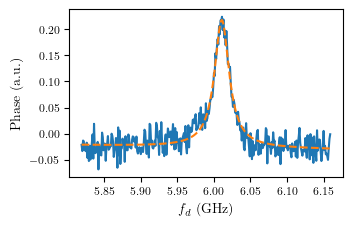

In [34]:
i =9
fig, ax = plt.subplots(figsize=set_size(textwidth,0.5))

freq_guess =freq[i][np.argmax(phi[i])]/1e9
peak1 = lmfit.models.LorentzianModel(prefix='l1_')
background = lmfit.models.LinearModel()
model = background + peak1 
model.param_names
params = model.make_params(slope=1e-5,intercept=np.min(phi_normalized[i]),l1_amplitude=0.15,l1_center=freq_guess,l1_sigma=0.15)
result = model.fit(phi_normalized[i], params, x=freq[i]/1e9)
plt.plot(freq[i]/1e9,phi_normalized[i])
plt.plot(freq[i]/1e9,result.best_fit,'--')
#plt.xticks([])  
 
# disabling yticks by setting yticks to an empty list
#plt.yticks([])  
plt.xlabel('$f_{d}$ (GHz)')
plt.ylabel('Phase (a.u.)')
#plt.savefig(path+'\\inset_paper_with_ticks.pdf',dpi=450,bbox_inches='tight')

In [102]:
from brokenaxes import brokenaxes

Supplementary Fig. 9

In [33]:
path = r"L:\Oliver\Measurment\Resonator_measurement\20230901_Gatemon_RT_5nm_2"
filename = r"L:\Oliver\Measurment\Resonator_measurement\20230901_Gatemon_RT_5nm_2\20230901_Gatemon_RT_5nm_2.db"
initialise_or_create_database_at(filename);


In [43]:
dataset = load_by_run_spec(captured_run_id=9) #freq setpoint is different for each gate voltage
data = _get_data_from_ds(dataset)

gate = data[0][0]['data']
freq  = data[0][1]['data']

phi = data[3][2]['data'] -np.mean(data[3][2]['data'],axis=1)[:,np.newaxis]
row_magnitudes = np.linalg.norm(phi, axis=1, keepdims=True)
phi_normalized = phi / row_magnitudes
R = data[2][2]['data'] -np.mean(data[2][2]['data'],axis=1)[:,np.newaxis]
gatemin = np.min(gate)
gatemax = np.max(gate)
dg = gate[:,0][1]-gate[:,0][0]
gatelen = int(np.abs((gatemax-gatemin)/dg)+1)
gates = np.arange(gatemax,gatemin+dg,dg)
df = freq[0][1]-freq[0][0]
fmin = np.min(freq)
fmax = np.max(freq)
flen = int((fmax-fmin)/df +1)
freqs = np.arange(fmin,fmax+df,df)
phi_new = np.full((gatelen,flen),np.NaN)
sorter = np.argsort(freqs)
for i in range(len(gate)):
    
    indexes = sorter[np.searchsorted(freqs, freq[i], sorter=sorter)]
    for count,element in enumerate(indexes):
        phi_new[i][element] = phi_normalized[i][count]
    

Trying to mark a run completed that was already completed.


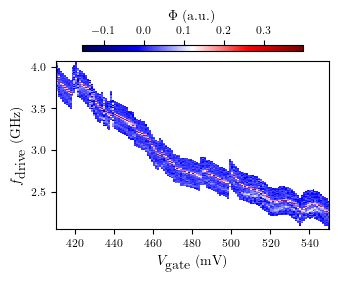

In [44]:
fig, ax = plt.subplots(figsize=set_size(textwidth,0.5))
#plt.plot(gate_plot,f_q, color='green', linewidth=2, linestyle='-.', label='Custom Line')
#plt.scatter(x=gate,y=freq/1e9,c=phi_normalized,cmap = 'seismic')
ax.imshow(np.flipud(np.transpose(np.flip(phi_new,0))),cmap='seismic'
           ,interpolation ='none',interpolation_stage='data',alpha=1
           ,extent =[gate[:,0][-1], gate[:,0][0],min(freqs)/1e9,max(freqs)/1e9],
           aspect='auto', vmin = np.min(phi_normalized), vmax = np.max(phi_normalized),resample=True)
plt.xlabel(r'$V_{\textrm{gate}}$ (mV)')
plt.ylabel(r'$f_{\textrm{drive}}$ (GHz)')
#plt.axvline(x=533, color='blue', linestyle=':', linewidth=1,alpha=0.7,label='')
norm = Normalize(vmin=np.min(phi_normalized[0:81]), vmax=np.max(phi_normalized[0:81]))
cax = fig.add_axes([0.2, 0.925, 0.625, 0.03])  # Adjust the position as needed

# Add a colorbar to the separate axis
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='seismic'), cax=cax, orientation='horizontal', label=r'$\Phi$ (a.u.)',location='top',shrink=0.75)

plt.savefig(path+'\\id_9_papersupp.pdf',dpi=450,bbox_inches='tight')

# Fig.2d, Supplementary Fig.5 -OPX Anharmonicity

In [118]:
path = 'Gatemon_RT_5nm_2/20230920_Gatemon_RT_5nm_2'
filename ='Gatemon_RT_5nm_2/20230920_Gatemon_RT_5nm_2/20230920_Gatemon_RT_5nm_2.db'

In [119]:
initialise_or_create_database_at(filename)

In [120]:
dataset = load_by_run_spec(captured_run_id=6) #freq setpoint is different for each gate voltage
data = _get_data_from_ds(dataset)


gate = data[0][0]['data']
freq  = data[0][1]['data']
fqubit = dataset.get_parameter_data('f_qubit')['f_qubit']['f_qubit']
phi = data[3][2]['data'] -np.mean(data[3][2]['data'],axis=1)[:,np.newaxis]
row_magnitudes = np.linalg.norm(phi, axis=1, keepdims=True)
phi_normalized = phi / row_magnitudes
R = data[2][2]['data'] -np.mean(data[2][2]['data'],axis=1)[:,np.newaxis]

Trying to mark a run completed that was already completed.


In [121]:
gatemin = np.min(gate)
gatemax = np.max(gate)
dg = gate[:,0][1]-gate[:,0][0]
gatelen = int(np.abs((gatemax-gatemin)/dg)+1)
gates = np.arange(gatemax,gatemin+dg,dg)
df = freq[0][1]-freq[0][0]
fmin = np.min(freq)
fmax = np.max(freq)
flen = int((fmax-fmin)/df +1)
freqs = np.arange(fmin,fmax+df,df)
phi_new = np.full((gatelen,flen),np.NaN)
sorter = np.argsort(freqs)
for i in range(len(gate)):
    
    indexes = sorter[np.searchsorted(freqs, freq[i], sorter=sorter)]
    for count,element in enumerate(indexes):
        phi_new[i][element] = phi_normalized[i][count]

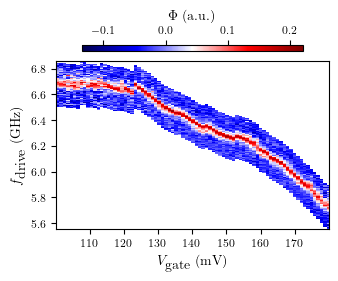

In [123]:
# Three tone spectroscopy
fig, ax = plt.subplots(figsize=set_size(textwidth,0.5))

ax.imshow(np.flipud(np.transpose(np.flip(phi_new,0))),cmap='seismic'
           ,interpolation ='none',interpolation_stage='data',alpha=1
           ,extent =[gate[:,0][-1], gate[:,0][0],min(freqs)/1e9,max(freqs)/1e9],
           aspect='auto', vmin = np.min(phi_normalized), vmax = np.max(phi_normalized),resample=True)
plt.xlabel(r'$V_{\textrm{gate}}$ (mV)')
plt.ylabel(r'$f_{\textrm{drive}}$ (GHz)')

norm = Normalize(vmin=np.min(phi_normalized), vmax=np.max(phi_normalized))
cax = fig.add_axes([0.2, 0.925, 0.625, 0.03])  # Adjust the position as needed

# Add a colorbar to the separate axis
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='seismic'), cax=cax, orientation='horizontal', label='$\Phi$ (a.u.)',location='top',shrink=0.75)

#plt.savefig(path+'\\id_6_anharmonicity_supplementary_noterp.pdf',dpi=450,bbox_inches='tight')

In [125]:
alpha = []
alpha_error = []
gate_plot = []
fq_plot=[]
for i in range(len(
    phi)):
    freq_guess =freq[i][np.argmax(phi[i])]/1e9
    peak1 = lmfit.models.LorentzianModel(prefix='l1_')
    background = lmfit.models.LinearModel()
    model = background + peak1 
    model.param_names
    params = model.make_params(slope=1e-6,intercept=np.min(phi_normalized[i]),
                               l1_amplitude=np.max(phi_normalized[i]),l1_center=freq_guess,l1_sigma=0.5)
    result = model.fit(phi_normalized[i], params, x=freq[i]/1e9)
    if result.chisqr < 0.4:
        if 0.3>np.abs(fqubit[i]/1e9-result.best_values['l1_center'])>0.01:
                alpha.append(fqubit[i]/1e9-result.best_values['l1_center'])
                fq_plot.append(fqubit[i])
                gate_plot.append(gate[i][0])

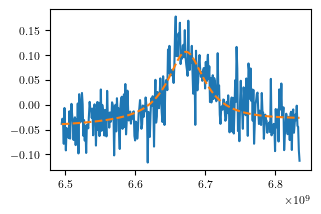

In [126]:
i = -4
freq_gues =freq[i][np.argmax(phi[i])]/1e9
peak1 = lmfit.models.LorentzianModel(prefix='l1_')
background = lmfit.models.LinearModel()
model = background + peak1 
model.param_names
params = model.make_params(slope=1e-6,intercept=np.min(phi_normalized[i]),l1_amplitude=np.max(phi_normalized[i]),
                           l1_center=freq_guess,l1_sigma=0.5)
result = model.fit(phi_normalized[i], params, x=freq[i]/1e9)
plt.plot(freq[i],phi_normalized[i])
plt.plot(freq[i],result.best_fit,'--')

Anharmonicity below the resonator

In [132]:
path = r'Gatemon_RT_5nm_2/20231020_Gatemon_RT_5nm_2'
filename =r'Gatemon_RT_5nm_2/20231020_Gatemon_RT_5nm_2/20231020_Gatemon_RT_5nm_2.db'

In [133]:
initialise_or_create_database_at(filename)


In [134]:
dataset = load_by_run_spec(captured_run_id=29) #freq setpoint is different for each gate voltage
data = _get_data_from_ds(dataset)


gate = data[0][0]['data']
freq  = data[0][1]['data']
fqubit = dataset.get_parameter_data('f_qubit')['f_qubit']['f_qubit']
phi = data[3][2]['data'] -np.mean(data[3][2]['data'],axis=1)[:,np.newaxis]
row_magnitudes = np.linalg.norm(phi, axis=1, keepdims=True)
phi_normalized = phi / row_magnitudes
R = data[2][2]['data'] -np.mean(data[2][2]['data'],axis=1)[:,np.newaxis]

Trying to mark a run completed that was already completed.


In [135]:
gatemin = np.min(gate)
gatemax = np.max(gate)
dg = gate[:,0][1]-gate[:,0][0]
gatelen = int(np.abs((gatemax-gatemin)/dg)+1)
gates = np.arange(gatemax,gatemin+dg,dg)
df = freq[0][1]-freq[0][0]
fmin = np.min(freq)
fmax = np.max(freq)
flen = int((fmax-fmin)/df +1)
freqs = np.arange(fmin,fmax+df,df)
phi_new = np.full((gatelen,flen),np.NaN)
sorter = np.argsort(freqs)
for i in range(len(gate)):
    
    indexes = sorter[np.searchsorted(freqs, freq[i], sorter=sorter)]
    for count,element in enumerate(indexes):
        phi_new[i][element] = phi_normalized[i][count]

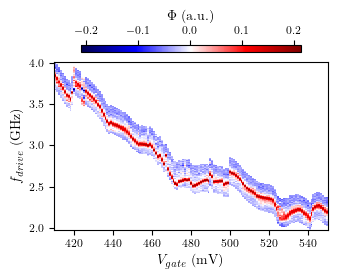

In [136]:

fig, ax = plt.subplots(figsize=set_size(textwidth,0.5))

ax.imshow(np.flipud(np.transpose(np.flip(phi_new,0))),cmap='seismic'
           ,interpolation ='none',interpolation_stage='data',alpha=1
           ,extent =[gate[:,0][-1], gate[:,0][0],min(freqs)/1e9,max(freqs)/1e9],
           aspect='auto', vmin = np.min(phi_normalized), vmax = np.max(phi_normalized),resample=True)
plt.xlabel('$V_{gate}$ (mV)')
plt.ylabel('$f_{drive}$ (GHz)')

norm = Normalize(vmin=np.min(phi_normalized), vmax=np.max(phi_normalized))
cax = fig.add_axes([0.2, 0.925, 0.625, 0.03])  # Adjust the position as needed

# Add a colorbar to the separate axis
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='seismic'), cax=cax, orientation='horizontal', label=r'$\Phi$ (a.u.)',location='top',shrink=0.75)

#plt.savefig(path+'\\id_29_anharmonicity_supplementary_nointerp.pdf',dpi=450,bbox_inches='tight')

#Plot merged data

In [44]:
data = np.loadtxt("L:\\Oliver\\Measurment\\Resonator_measurement\\20230920_Gatemon_RT_5nm_2\\anharmonicity_merged.txt")

Text(0.5, 0, '$V_{\\textrm{gate}}$ (mV)')

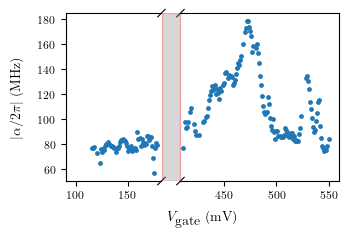

In [50]:
gate=data[0]
alpha = data[1]


baxes = brokenaxes(xlims=((90,182),(408,560)) , hspace=.15, wspace=0.15, despine=False,fig=plt.figure(figsize=set_size(textwidth,0.5)))

baxes.scatter(gate,alpha,color='#1f77b4',s=6)

newax = baxes.fig.add_axes((0,0,0.5,0.5), frameon=False)


newax.set_position([0.125,0.10999,0.9-0.125,0.88-0.10999])

newax.add_patch(Rectangle((0.354, 0), 0.065, 1,alpha=0.3,facecolor='gray',edgecolor='red',lw=1,antialiased=True))

newax.set_xticks([])
newax.set_yticks([]) 




newax.set_xlabel('')
newax.set_ylabel('')

baxes.set_ylabel(r'$|\alpha/ 2 \pi|$ (MHz)',labelpad=30)
baxes.set_xlabel(r'$V_{\textrm{gate}}$ (mV)',labelpad=21)

#baxes.set_ylim(50,200)

#plt.savefig(path+'\\anharmonicity_brokenaxes_paper.pdf',dpi=200,bbox_inches='tight')

# Fig3a-b, Supplementary Fig9 - OPX Time domain


## Rabi

In [137]:
path = 'Gatemon_RT_5nm_2/20230814_Gatemon_RT_5nm_2'
filename = "Gatemon_RT_5nm_2\\20230814_Gatemon_RT_5nm_2\\20230814_Gatemon_RT_5nm_2.db"

In [138]:
initialise_or_create_database_at(filename)


In [139]:
from scipy.optimize import curve_fit
def rabi(t,A,freq,tau,phase,offset):
    return A*np.exp(-t/tau)*np.cos(2*np.pi*freq*t+phase) + offset

In [140]:
def linear(x,slope,intercept):
    return slope*x+intercept

In [141]:
dataset = load_by_run_spec(captured_run_id=74)
data =_get_data_from_ds(dataset)

Trying to mark a run completed that was already completed.


In [143]:
amp = data[1][0]['data'][:,0]
time = data[1][1]['data'][0]
phase = data[1][2]['data']-np.mean(data[1][2]['data'], axis=1)[:,np.newaxis]


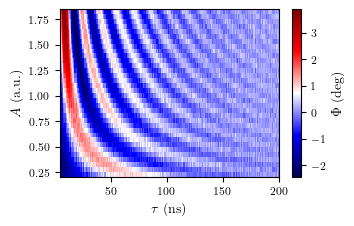

In [144]:
plt.figure(figsize=set_size(textwidth,0.5))
plt.imshow(np.flipud(phase),cmap='seismic'
           ,interpolation ='none'
           ,extent =[time[0],time[-1],amp[0], amp[-1]],
           aspect='auto', vmin = np.min(phase), vmax = np.max(phase))
plt.xlabel(r'$\tau$ (ns)')
plt.ylabel(r'$A$ (a.u.)')
plt.colorbar(label=r'$\Phi$ (deg)')

#plt.savefig(path+'\\id_74_paper_nointerp.pdf',dpi=450,bbox_inches='tight')

C:\Users\osagi\AppData\Local\Temp\ipykernel_11048\2830448850.py:3: RuntimeWarning: overflow encountered in exp
  return A*np.exp(-t/tau)*np.cos(2*np.pi*freq*t+phase) + offset


Text(0, 0.5, 'Phase (deg)')

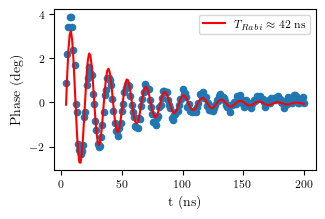

In [146]:
plt.figure()
popt, pcov = curve_fit(rabi, time, phase[-1], p0=[2,0.1,10,0.1,0])

plt.plot(time,rabi(time,*popt),'r',label=r'$T_{{Rabi}} \approx {:.0f} $ ns'.format(popt[2]))
plt.scatter(time,phase[-1],s=20)
plt.legend()
plt.xlabel(' t (ns)')
plt.ylabel('Phase (deg)')
#plt.savefig(path+'\\id_74_linecut.pdf',dpi=100,bbox_inches='tight')

In [147]:
params =[]
freqcovs = []
for i in range(len(amp)):
    popt, pcov = curve_fit(rabi, time, phase[i], p0=[2,0.1,10,0.1,0])
    params.append(popt)
    freqcovs.append(1e3*np.sqrt(pcov[1][1]))

C:\Users\osagi\AppData\Local\Temp\ipykernel_11048\2830448850.py:3: RuntimeWarning: overflow encountered in exp
  return A*np.exp(-t/tau)*np.cos(2*np.pi*freq*t+phase) + offset


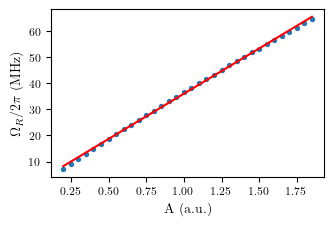

In [149]:
plt.figure(figsize=set_size(textwidth,0.5))
plt.scatter(amp,rabi_freqs,s=8)
popt, pcov = curve_fit(linear, amp, rabi_freqs, p0=[1,0])
plt.plot(amp,linear(amp,*popt),'r-')
plt.xlabel('A (a.u.)')
plt.ylabel('$\Omega_{R} / 2 \pi $ (MHz)')
#plt.savefig(path+'\\rabi_freq.pdf',dpi=100,bbox_inches='tight')

Text(0, 0.5, '$T_{R}$ (ns)')

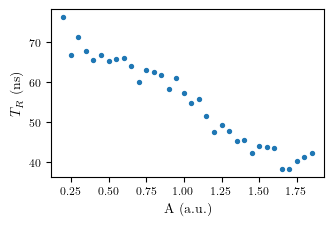

In [150]:
plt.figure(figsize=set_size(textwidth,0.5))
plt.scatter(amp,np.array(params)[:,2],s=8)
plt.xlabel('A (a.u.)')
plt.ylabel('$T_{R}$ (ns)')
#plt.savefig(path+'\\rabi_times.pdf',dpi=100,bbox_inches='tight')

## Rabi_Chevron - not shown

In [151]:
dataset = load_by_run_spec(captured_run_id=88)
data =_get_data_from_ds(dataset)
amp = data[1][0]['data'][:,0]
time = data[1][1]['data'][0]
phase = data[1][2]['data']-np.mean(data[1][2]['data'], axis=1)[:,np.newaxis]

Trying to mark a run completed that was already completed.


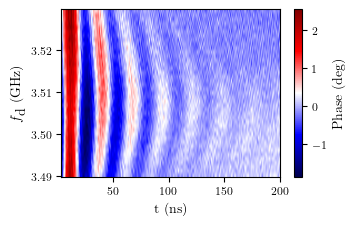

In [152]:
plt.figure(figsize=set_size(textwidth,0.5))
plt.imshow(np.flipud(phase),cmap='seismic'
           ,interpolation ='spline16',interpolation_stage='rgba'
           ,extent =[time[0],time[-1],amp[0]/1e9+3.65389, amp[-1]/1e9+3.65389],
           aspect='auto', vmin = np.min(phase), vmax = np.max(phase))
plt.xlabel('t (ns)')
plt.ylabel(r'$f_{\textrm{d}}$ (GHz)')
plt.colorbar(label='Phase (deg)')
#plt.savefig(path+'\\id_88.pdf',dpi=450,bbox_inches='tight')

## Ramsey

In [153]:
filename =r'Gatemon_RT_5nm_2/20231020_Gatemon_RT_5nm_2/20231020_Gatemon_RT_5nm_2.db'
initialise_or_create_database_at(filename)

In [154]:
dataset = load_by_run_spec(captured_run_id=25)
data =_get_data_from_ds(dataset)
amp = data[3][0]['data'][:,0]
time = data[3][1]['data'][0]
phase = data[3][2]['data']-np.mean(data[3][2]['data'], axis=1)[:,np.newaxis]

Trying to mark a run completed that was already completed.


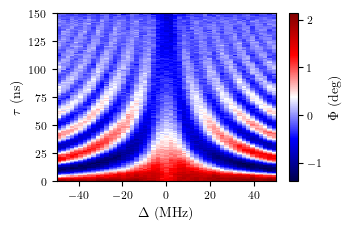

In [155]:
plt.figure(figsize=set_size(textwidth,0.5))
plt.imshow(np.flipud(np.transpose(phase)),cmap='seismic'
           ,interpolation ='none',interpolation_stage='rgba'
           ,extent =[amp[0]/1e6, amp[-1]/1e6, time[0],time[-1]],
           aspect='auto', vmin = np.min(phase), vmax = np.max(phase))
plt.ylabel(r'$\tau$ (ns)')
plt.xlabel(r'$\Delta$ (MHz)')
plt.colorbar(label='$\Phi$ (deg)')

#plt.savefig(path+'\\id_25_nointerp.pdf',dpi=450,bbox_inches='tight')

# OPX Qubit fit

In [37]:
def opx_qubit_fit(meas_id):
    dataset = load_by_run_spec(captured_run_id=meas_id)
    data =_get_data_from_ds(dataset)
    freq = phase =data[3][0]['data'].flatten()
    phi =data[3][1]['data'].flatten()
    freq_guess = freq[np.argmax(phi)]/1e9 
    peak1 = lmfit.models.LorentzianModel(prefix='l1_')
    background = lmfit.models.LinearModel()
    model = background + peak1 
    model.param_names
    params = model.make_params(slope=1e-9,intercept=np.min(phi),l1_amplitude=0.75,l1_center=freq_guess,l1_sigma=0.025)
    result = model.fit(phi, params, x=freq/1e9)
    return result.best_values['l1_center']

In [38]:
dataset = load_by_run_spec(captured_run_id=30)
data =_get_data_from_ds(dataset)

NameError: No run matching the supplied information found.

In [ ]:
freq = phase =data[3][0]['data'].flatten()
phi =data[3][1]['data'].flatten()

In [ ]:
freq_guess = freq[np.argmax(phi)]/1e9 
peak1 = lmfit.models.LorentzianModel(prefix='l1_')
background = lmfit.models.LinearModel()
model = background + peak1 
model.param_names
params = model.make_params(slope=1e-9,intercept=np.min(phi),l1_amplitude=0.75,l1_center=freq_guess,l1_sigma=0.025)
result = model.fit(phi, params, x=freq/1e9)

In [ ]:
plt.figure()
plt.scatter(freq,phi)
plt.plot(freq,result.best_fit,'r--', linewidth=3)

In [ ]:
qubit_freq.append(result.best_values['l1_center'])

## Fig. 5b - Transmon Fit

In [39]:
path = 'Al_Transmon/20230628_Al_Transmon_11170_20mK'
filename = 'Al_Transmon/20230628_Al_Transmon_11170_20mK/20230628_Al_Transmon_11170_20mK.db'
initialise_or_create_database_at(filename)

In [40]:
dataset = load_by_run_spec(captured_run_id=30)
data =_get_data_from_ds(dataset)

Trying to mark a run completed that was already completed.


In [41]:
freq =data[0][0]['data'].flatten()
phi =data[1][1]['data'].flatten()

In [42]:
freq_guess = freq[np.argmax(phi)]/1e9 
peak1 = lmfit.models.LorentzianModel(prefix='l1_')
background = lmfit.models.LinearModel()
model = background + peak1 
model.param_names
params = model.make_params(slope=1e-9,intercept=np.min(phi),l1_amplitude=0.75,l1_center=freq_guess,l1_sigma=0.025)
result = model.fit(phi, params, x=freq/1e9)

Text(0, 0.5, '$\\Phi$ (deg)')

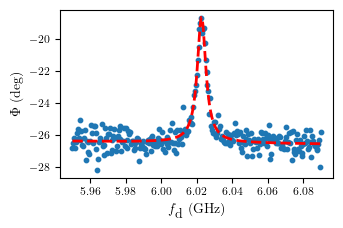

In [43]:
plt.figure(figsize=set_size(textwidth,0.5))
plt.scatter(freq/1e9,phi,s=10)
plt.plot(freq/1e9,result.best_fit,'r--', linewidth=2)
 
plt.xlabel(r'$f_{\textrm{d}}$ (GHz)')
plt.ylabel(r'$\Phi$ (deg)')
#plt.savefig(path+'\\id_30_qubitfitforpaper.pdf',dpi=150,bbox_inches='tight')

## Supplementary Figure 2

In [72]:
path = 'L:/Oliver/Measurment/Resonator_measurement/20230703_Al_Transmon_10891_20mK'
filename = 'L:/Oliver/Measurment/Resonator_measurement/20230703_Al_Transmon_10891_20mK/20230703_Al_Transmon_10891_20mK.db'
initialise_or_create_database_at(filename)

In [73]:
dataset = load_by_run_spec(captured_run_id=14)
data =_get_data_from_ds(dataset)

Trying to mark a run completed that was already completed.


In [74]:
freq =data[0][0]['data'].flatten()
phi =data[1][1]['data'].flatten()
freq_guess = freq[np.argmax(phi)]/1e9 
peak1 = lmfit.models.LorentzianModel(prefix='l1_')
background = lmfit.models.LinearModel()
model = background + peak1 
model.param_names
params = model.make_params(slope=1e-9,intercept=np.min(phi),l1_amplitude=0.75,l1_center=freq_guess,l1_sigma=0.025)
result = model.fit(phi, params, x=freq/1e9)

Text(0, 0.5, 'Phase (deg)')

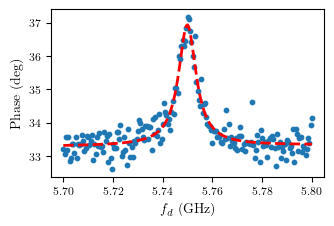

In [75]:
plt.figure(figsize=set_size(textwidth,0.5))
plt.scatter(freq/1e9,phi,s=10)
plt.plot(freq/1e9,result.best_fit,'r--', linewidth=2)
 
plt.xlabel(r'$f_{d}$ (GHz)')
plt.ylabel('Phase (deg)')
#plt.savefig(path+'\\id_14_qubitfit.pdf',dpi=150,bbox_inches='tight')

'L:/Oliver/Measurment/Resonator_measurement/20230711_Al_Transmon_10891_20mK'

In [77]:
dataset = load_by_run_spec(captured_run_id=6)
data =_get_data_from_ds(dataset)
freq =data[0][0]['data'].flatten()
phi =data[1][1]['data'].flatten()
freq_guess = freq[np.argmax(phi)]/1e9 
peak1 = lmfit.models.LorentzianModel(prefix='l1_')
background = lmfit.models.LinearModel()
model = background + peak1 
model.param_names
params = model.make_params(slope=1e-9,intercept=np.min(phi),l1_amplitude=0.75,l1_center=freq_guess,l1_sigma=0.025)
result = model.fit(phi[540:], params, x=freq[540:]/1e9)

Trying to mark a run completed that was already completed.


TypeError: Improper input: func input vector length N=5 must not exceed func output vector length M=0

In [ ]:
plt.figure(figsize=set_size(textwidth,0.5))
plt.scatter(freq[540:]/1e9,phi[540:],s=10)
plt.plot(freq[540:]/1e9,result.best_fit,'r--', linewidth=2)
 
plt.xlabel(r'$f_{d}$ (GHz)')
plt.ylabel('Phase (deg)')
plt.savefig(path+'\\id_6_qubitfit.pdf',dpi=150,bbox_inches='tight')

# Fig 4a - T1


In [48]:
filename = r"Gatemon_RT_5nm_2/20231010_Gatemon_RT_5nm_2/20231010_Gatemon_RT_5nm_2.db"
path = r"Gatemon_RT_5nm_2/20231010_Gatemon_RT_5nm_2"
initialise_or_create_database_at(filename)

In [49]:
def func_T1(x, a, b, c):
    return a * (np.exp(-x/b))+c

In [50]:
def opx_T1_fit(meas_id):
    dataset1 = load_by_run_spec(captured_run_id=meas_id)
    data =_get_data_from_ds(dataset1)
    time = data[0][0]['data'].flatten()
    phase = data[3][1]['data'].flatten()    
    popt, pcov = curve_fit(func_T1, time, phase,p0=[3,20,np.min(phase)])
    
    return [popt[1],np.sqrt(pcov[1][1])]
    

In [51]:
dataset1 = load_by_run_spec(captured_run_id=64)
data =_get_data_from_ds(dataset1)

Trying to mark a run completed that was already completed.


In [52]:
time = data[0][0]['data'].flatten()
phase = data[3][1]['data'].flatten()

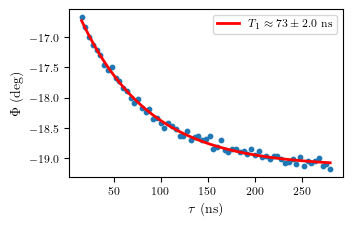

In [53]:
plt.figure(figsize=set_size(textwidth,0.5))
popt, pcov = curve_fit(func_T1, time, phase,p0=[3,20,52])

plt.scatter(time,phase,s=10)
plt.plot(time, func_T1(time, *popt),'r',linewidth=2,
         label=r'$T_{{1}} \approx {:.0f} \pm {:.1f} $ ns'.format(popt[1],np.sqrt(pcov[1][1])))
plt.xlabel(r'$\tau$ (ns)')
plt.ylabel(r'$\Phi$ (deg)')
plt.legend()
#plt.savefig(path+'\\id_64_T1forpaper.pdf',dpi=100,bbox_inches='tight')

## Fig. 5c -Transmon fit


In [54]:
path = 'Al_Transmon/20230629_Al_Transmon_11170_20mK'
filename = 'Al_Transmon/20230629_Al_Transmon_11170_20mK/20230629_Al_Transmon_11170_20mK.db'
initialise_or_create_database_at(filename)

In [55]:
dataset1 = load_by_run_spec(captured_run_id=22)
data =_get_data_from_ds(dataset1)

Trying to mark a run completed that was already completed.


In [56]:
time = data[0][0]['data'].flatten()
phase = data[1][1]['data'].flatten()

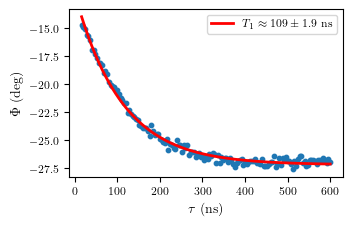

In [57]:
plt.figure(figsize=set_size(textwidth,0.5))
popt, pcov = curve_fit(func_T1, time, phase,p0=[3,20,52])

plt.scatter(time,phase,s=10)
plt.plot(time, func_T1(time, *popt),'r',linewidth=2,
         label=r'$T_{{1}} \approx {:.0f} \pm {:.1f} $ ns'.format(popt[1],np.sqrt(pcov[1][1])))
plt.xlabel(r'$\tau$ (ns)')
plt.ylabel(r'$\Phi$ (deg)')
plt.legend()
#plt.savefig(path+'\\id_22_T1forpaper.pdf',dpi=100,bbox_inches='tight')

# Supplementary Fig. 6 

In [65]:
filename = 'Al_Transmon/20230703_Al_Transmon_11170_20mK/20230703_Al_Transmon_11170_20mK.db'
initialise_or_create_database_at(filename)

In [66]:
dataset1 = load_by_run_spec(captured_run_id=29)
data =_get_data_from_ds(dataset1)
time = data[0][0]['data'].flatten()
phase = data[1][1]['data'].flatten()

Trying to mark a run completed that was already completed.


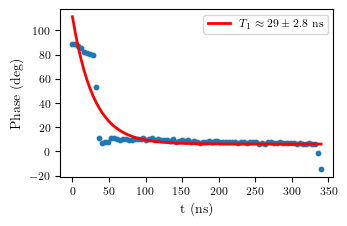

In [67]:
plt.figure(figsize=set_size(textwidth,0.5))
popt, pcov = curve_fit(func_T1, time, phase,p0=[3,20,52])

plt.scatter(time,phase,s=10)
plt.plot(time, func_T1(time, *popt),'r',linewidth=2,
         label=r'$T_{{1}} \approx {:.0f} \pm {:.1f} $ ns'.format(popt[1],np.sqrt(pcov[1][1])))
plt.xlabel('t (ns)')
plt.ylabel('Phase (deg)')
plt.legend()
#plt.savefig(path+'\\id_29_T1.pdf',dpi=100,bbox_inches='tight')

'L:/Oliver/Measurment/Resonator_measurement/20230711_Al_Transmon_10891_20mK'

In [ ]:
filename = 'Al_Transmon/20230703_Al_Transmon_11170_20mK/20230703_Al_Transmon_11170_20mK.db'
initialise_or_create_database_at(filename)

In [ ]:
dataset1 = load_by_run_spec(captured_run_id=16)
data =_get_data_from_ds(dataset1)
time = data[0][0]['data'].flatten()
phase = data[1][1]['data'].flatten()

In [ ]:
plt.figure(figsize=set_size(textwidth,0.5))
popt, pcov = curve_fit(func_T1, time, phase,p0=[3,20,52])

plt.scatter(time,phase,s=10)
plt.plot(time, func_T1(time, *popt),'r',linewidth=2,
         label=r'$T_{{1}} \approx {:.0f} \pm {:.1f} $ ns'.format(popt[1],np.sqrt(pcov[1][1])))
plt.xlabel('t (ns)')
plt.ylabel('Phase (deg)')
plt.legend()
plt.savefig(path+'\\id_16_T1.pdf',dpi=100,bbox_inches='tight')

# Fig 4 - OPX T2

In [16]:
filename = r"Gatemon_RT_5nm_2/20231012_Gatemon_RT_5nm_2/20231012_Gatemon_RT_5nm_2.db"
path = r"Gatemon_RT_5nm_2/20231012_Gatemon_RT_5nm_2"
initialise_or_create_database_at(filename)

In [17]:
def func_T2(x, a, b, f, phi, c, d):
    return a * np.exp(-x/b) * np.cos(2*np.pi*f*x + phi) + c + d*x

In [18]:
def opx_T2_fit(meas_id):
    dataset1 = load_by_run_spec(captured_run_id=meas_id)
    data =_get_data_from_ds(dataset1)
    time = data[0][0]['data'].flatten()
    phase = data[3][1]['data'].flatten()
    popt, pcov = curve_fit(func_T2, time, phase,p0=[0.5,25,0.05,0,phase[-1], 0])
    
    return [popt[1],np.sqrt(pcov[1][1])]

In [19]:
dataset1 = load_by_run_spec(captured_run_id=23)
data =_get_data_from_ds(dataset1)
time = data[0][0]['data'].flatten()
R = 10**(data[0][1]['data'].flatten()/20)
phase = data[3][1]['data'].flatten()

Trying to mark a run completed that was already completed.


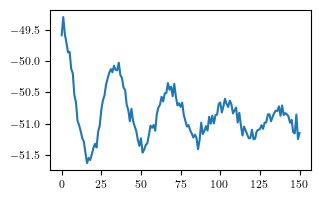

In [20]:
plt.plot(time,phase)

C:\Users\osagi\AppData\Local\Temp\ipykernel_15488\3346891827.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-x/b) * np.cos(2*np.pi*f*x + phi) + c + d*x


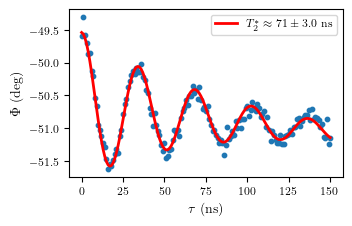

In [22]:
plt.figure(figsize=set_size(textwidth,0.5))
popt, pcov = curve_fit(func_T2, time, phase,p0=[1,25,0.05,0,phase[-1], 0])

plt.scatter(time,phase,s =10)
plt.plot(time, func_T2(time, *popt),'r',linewidth=2,
         label=r'$T_{{2}}^{{*}} \approx {:.0f} \pm {:.1f} $ ns '.format(popt[1],np.sqrt(pcov[1][1])))
plt.xlabel(r'$\tau$ (ns)')
plt.ylabel(r'$\Phi$ (deg)')
plt.legend()
#plt.savefig(path+'\\id_23_T2starforpaper.pdf',dpi=100,bbox_inches='tight')

## Fig 5 - Transmon fit

In [23]:
path = r'Al_Transmon/20230701_Al_Transmon_11170_20mK'
filename= r'Al_Transmon/20230701_Al_Transmon_11170_20mK/20230701_Al_Transmon_11170_20mK.db'
initialise_or_create_database_at(filename)

In [24]:
dataset1 = load_by_run_spec(captured_run_id=8)
data =_get_data_from_ds(dataset1)
time = data[0][0]['data'].flatten()
R = 10**(data[0][1]['data'].flatten()/20)
phase = data[1][1]['data'].flatten()

Trying to mark a run completed that was already completed.


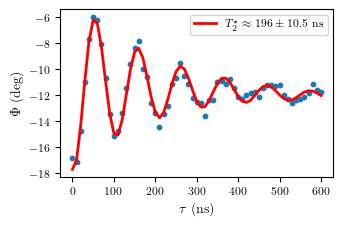

In [36]:
plt.figure(figsize=set_size(textwidth,0.5))
popt, pcov = curve_fit(func_T2, time, phase,p0=[10,10,0.001,0,-12, 0.0])

plt.scatter(time,phase,s =10)
plt.plot(time, func_T2(time, *popt),'r',linewidth=2,
         label=r'$T_{{2}}^{{*}} \approx {:.0f} \pm {:.1f} $ ns '.format(popt[1],np.sqrt(pcov[1][1])))
plt.xlabel(r'$\tau$ (ns)')
plt.ylabel(r'$\Phi$ (deg)')
plt.legend()
#plt.savefig(path+'\\id_8_T2starforpaper.pdf',dpi=100,bbox_inches='tight')

# Qubit T1,T2 vs freq

In [156]:
def get_gatev(meas_id):
    dataset = load_by_run_spec(captured_run_id=meas_id)
    return dataset.snapshot['station']['instruments']['IVVI']['parameters']['dac10']['raw_value']

In [157]:
qubit_freq = []
qubit_T1 = []
qubit_T2 = []
qubit_gate = []

In [158]:
qubit_T1_error = []
qubit_T2_error = []

In [159]:
file1 = "Gatemon_RT_5nm_2/20231010_Gatemon_RT_5nm_2/20231010_Gatemon_RT_5nm_2.db"
file2 = "Gatemon_RT_5nm_2/20231011_Gatemon_RT_5nm_2/20231011_Gatemon_RT_5nm_2.db"
file3 = "Gatemon_RT_5nm_2/20231012_Gatemon_RT_5nm_2/20231012_Gatemon_RT_5nm_2.db"

In [160]:
qubit_id1 = [10,18,24,34,40,50,62]
T1_id1 = [13,20,26,36,43,53,64]
T2_id1 = [15,21,27,37,44,54,65]
qubit_id2 = [6,14]
T1_id2 = [9,16]
T2_id2 = [11,17]
qubit_id3 = [2,11,19,27,33,39,45]
T1_id3 = [5,13,22,29,35,41,47]
T2_id3 = [8,14,23,31,36,42,48]


In [161]:
qubit_ids = [qubit_id1,qubit_id2,qubit_id3]
T1_ids = [T1_id1,T1_id2,T1_id3]
T2_ids = [T2_id1,T2_id2,T2_id3]

In [346]:
for counter,filename in enumerate([file1,file2,file3]):
    initialise_or_create_database_at(filename);
    for meas_id in qubit_ids[counter]:
        qubit_freq.append(opx_qubit_fit(meas_id))
        qubit_gate.append(get_gatev(meas_id))
    for meas_id in T1_ids[counter]:    
        T1,T1err = opx_T1_fit(meas_id)
        qubit_T1.append(T1)
        qubit_T1_error.append(T1err)
    for meas_id in T2_ids[counter]:
        T2,T2err = opx_T2_fit(meas_id)
        qubit_T2.append(T2)
        qubit_T2_error.append(T2err)
     
        

Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already complete

In [ ]:
plt.figure(figsize=(4,3))
plt.scatter(qubit_freq,qubit_T1)
plt.errorbar(qubit_freq, qubit_T1, yerr=qubit_T1_error, fmt="o")
plt.ylim(0,85)
plt.ylabel('$T_{1}$ (ns)')
plt.xlabel('$f_{qubit}$ (GHz)')

In [ ]:
plt.figure(figsize=(4,3))
plt.scatter(qubit_freq,qubit_T2)
plt.errorbar(qubit_freq, qubit_T2, yerr=qubit_T2_error, fmt="o")
plt.ylim(0,90)

plt.ylabel('$T_{2}$ (ns)')
plt.xlabel('$f_{qubit}$ (GHz)')

In [ ]:
plt.figure(figsize=(4,3))
plt.scatter(qubit_gate,qubit_T2)
plt.ylim(0,80)
plt.ylabel('$T_{2}$ (ns)')
plt.xlabel('$V_{gate}$ (mV)')

In [ ]:
np.savetxt(path+'\\qubit_coherence.txt',np.array([qubit_gate,qubit_freq,qubit_T1,qubit_T2,qubit_T1_error,qubit_T2_error]),
                                           header='gate,freq,T1,T2,T1_error,T2_error')

In [347]:
file1 = "L:/Oliver/Measurment/Resonator_measurement/20231027_Gatemon_RT_5nm_2/20231027_Gatemon_RT_5nm_2.db"
file2 = "L:/Oliver/Measurment/Resonator_measurement/20231030_Gatemon_RT_5nm_2/20231030_Gatemon_RT_5nm_2.db"

In [348]:
qubit_id1 = [4]
T1_id1 = [7]
T2_id1 = [8]
qubit_id2 = [5,14,21,28,38,47,54,63]
T1_id2 = [8,17,24,30,40,50,56,65]
T2_id2 = [9,19,25,32,41,52,57,66]
qubit_ids = [qubit_id1,qubit_id2]
T1_ids = [T1_id1,T1_id2]
T2_ids = [T2_id1,T2_id2]

In [349]:
for counter,filename in enumerate([file1,file2]):
    initialise_or_create_database_at(filename);
    for meas_id in qubit_ids[counter]:
        qubit_freq.append(opx_qubit_fit(meas_id))
        qubit_gate.append(get_gatev(meas_id))
    for meas_id in T1_ids[counter]:    
        T1,T1err = opx_T1_fit(meas_id)
        qubit_T1.append(T1)
        qubit_T1_error.append(T1err)
    for meas_id in T2_ids[counter]:
        T2,T2err = opx_T2_fit(meas_id)
        qubit_T2.append(T2)
        qubit_T2_error.append(T2err)
     
        

Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already complete

In [353]:
def Q_fit(x,Q):
    return Q/(2*np.pi*x)

In [354]:
popt, pcov = curve_fit(Q_fit,qubit_freq,qubit_T1,p0=[500],sigma=qubit_T1_error)

In [355]:
np.sqrt(pcov)

array([[23.26523149]])

AttributeError: Line2D.set() got an unexpected keyword argument 's'

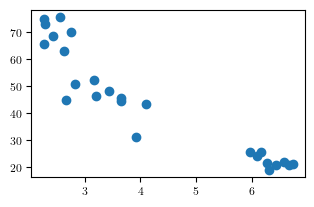

In [324]:
plt.figure(figsize=set_size(textwidth,0.5))
plt.scatter(qubit_freq,qubit_T1)
plt.errorbar(qubit_freq, qubit_T1, yerr=qubit_T1_error,s=10, fmt="o")
plt.plot(np.sort(qubit_freq),Q_fit(np.array(np.sort(qubit_freq)),*popt),
         '--',linewidth=2,label=r'$T_{1} \approx \frac{\overline{Q}}{2\pi \cdot f_{\textrm{q}}}$')
plt.ylim(0,90)
plt.xlim(2,7)
plt.ylabel('$T_{1}$ (ns)')
plt.xlabel(r'$f_{\textrm{qubit}}$ (GHz)')
plt.legend()
plt.text(4.8,50,r'$\overline{Q} \approx 982\, \left(\pm 23\right) $',fontsize=12)
#plt.savefig(path+'\\T1_fullrange_noitalic.pdf',dpi=100,bbox_inches='tight')

In [163]:
zipped_pairs = zip(qubit_freq,qubit_T2,qubit_T2_error,qubit_T1)
# Then, sort the zipped pairs based on the elements of the first array
sorted_pairs = sorted(zipped_pairs)

# Finally, unzip the sorted pairs
sorted_array1, sorted_array2,sorted_array3,sorted_array4 = zip(*sorted_pairs)

Text(0.5, 0, '$f_{qubit}$ (GHz)')

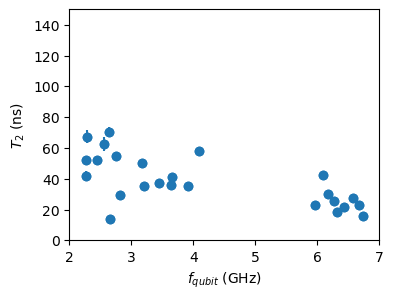

In [23]:
plt.figure(figsize=(4,3))
plt.scatter(sorted_array1,sorted_array2)
plt.errorbar(sorted_array1, sorted_array2, yerr=sorted_array3, fmt="o")

plt.ylim(0,150)
plt.xlim(2,7)
plt.ylabel('$T_{2}$ (ns)')
plt.xlabel('$f_{qubit}$ (GHz)')

Text(0.5, 0, '$f_{qubit}$ (GHz)')

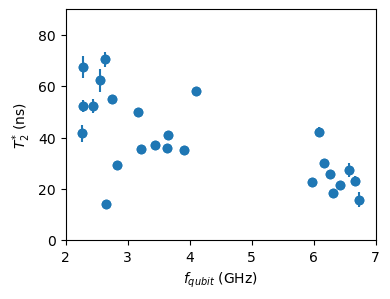

In [24]:
plt.figure(figsize=(4,3))
plt.scatter(qubit_freq,qubit_T2)
plt.errorbar(qubit_freq, qubit_T2, yerr=qubit_T2_error, fmt="o")

plt.ylim(0,90)
plt.xlim(2,7)
plt.ylabel('$T_{2}^{*}$ (ns)')
plt.xlabel('$f_{qubit}$ (GHz)')
#plt.savefig(path+'\\T2_fullrange.pdf',dpi=100,bbox_inches='tight')

In [35]:
qubit_T1*2


[46.290109909285775,
 48.277034519680335,
 44.405925844048355,
 45.60260859065699,
 31.28459706270027,
 43.57183670313967,
 73.00598146595625,
 74.79573643459769,
 65.63938714137261,
 68.75120224014218,
 75.61635202214657,
 63.25221356082797,
 44.98311319654546,
 70.22396401426654,
 50.73545637749614,
 52.450589191849126,
 25.71620409213363,
 24.37594722224836,
 25.523306763327437,
 21.528338742365097,
 19.11717711908373,
 20.983741623685553,
 22.17114156251141,
 21.010115982062192,
 21.21157646936575,
 46.290109909285775,
 48.277034519680335,
 44.405925844048355,
 45.60260859065699,
 31.28459706270027,
 43.57183670313967,
 73.00598146595625,
 74.79573643459769,
 65.63938714137261,
 68.75120224014218,
 75.61635202214657,
 63.25221356082797,
 44.98311319654546,
 70.22396401426654,
 50.73545637749614,
 52.450589191849126,
 25.71620409213363,
 24.37594722224836,
 25.523306763327437,
 21.528338742365097,
 19.11717711908373,
 20.983741623685553,
 22.17114156251141,
 21.010115982062192,
 21.

#Dephasing for white noise:

$$\Gamma_{\phi} = PSD \pi^{2} \left(\frac{\partial f_{01}}{\partial V}\right)^{2} $$

$$ PSD = \frac{V_{rms}^{2}}{BW}$$

In [19]:
sensitivity = 1e6 / 100e-6 # in Hz/V , 1MHz change for 100uV gate voltage

In [20]:
psd = 10**-12 #in V**2/Hz, from Daniel measurement

In [ ]:
dephasing_limit = ((np.pi**2)*psd*(sensitivity**2))**-1
dephasing_limit*1e6

In [27]:
sensitivity = 1e9 # in Hz/Phi0
psd = (60*1e-9)**20 #flux noise form the Delft paper
dephasing_rate = ((np.pi**2)*psd*(sensitivity**2))
dephasing_rate/1e6

0.0355305758439217

In [28]:
sensitivity  = 1e9 # in Hz/V
psd = 10**-12 #in V**2/Hz, from Delft supplementary
dephasing_limit = ((np.pi**2)*psd*(sensitivity**2))**-1
dephasing_limit*1e9

101.32118364233779

#Dephasingm for 1/f noise

$$ PSD = \frac{A}{f}$$

$$\Gamma_{\phi} = \sqrt{A} 2\pi\sqrt{ln(2)} \left(\frac{\partial f_{01}}{\partial V}\right) $$

In [100]:
A = 300e-6 #voltage noise amplitude
dephasing_limit = (A*2*np.pi*np.sqrt(np.log(2))*sensitivity)**-1
dephasing_limit*1e9

63.72152287226924

In [30]:
#Delft numberus
sensitivity = 1e9
A = 1e-6 #voltage noise amplitude, Delft supplementary
dephasing_limit = (A*2*np.pi*np.sqrt(np.log(2))*sensitivity)**-1
dephasing_limit*1e6

191.1645686168077

In [46]:
qubit_dephasing = np.power(np.power(qubit_T2,-1)-0.5*np.power(qubit_T1,-1),-1)
qubit_dephasing_rate = np.power(qubit_T2,-1)-0.5*np.power(qubit_T1,-1)
error_1 = np.power(qubit_dephasing_rate,-2)*np.power(qubit_T2,-2)*qubit_T2_error
error_2 = -0.5*np.power(qubit_dephasing_rate,-2)*np.power(qubit_T1,-2)*qubit_T1_error

Text(0.5, 0, '$f_{qubit}$ (GHz)')

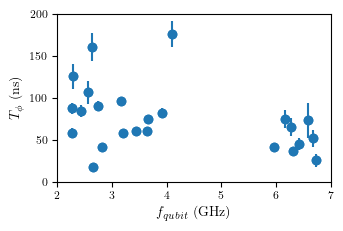

In [63]:
plt.figure(figsize=set_size(textwidth,0.5))
plt.scatter(qubit_freq,qubit_dephasing)
plt.errorbar(qubit_freq, qubit_dephasing, yerr=np.sqrt(error_1**2+error_2**2), fmt="o")
plt.ylim(0,200)
plt.xlim(2,7)
plt.ylabel('$T_{\phi}$ (ns)')
plt.xlabel('$f_{qubit}$ (GHz)')

Text(0.5, 0, '$V_{gate}$ (mV)')

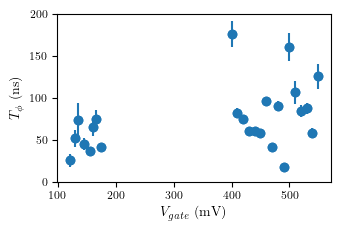

In [114]:
plt.figure(figsize=set_size(textwidth,0.5))
plt.scatter(qubit_gate,qubit_dephasing)
plt.errorbar(qubit_gate, qubit_dephasing, yerr=np.sqrt(error_1**2+error_2**2), fmt="o")
plt.ylim(0,200)

plt.ylabel('$T_{\phi}$ (ns)')
plt.xlabel('$V_{gate}$ (mV)')

In [ ]:
plt.figure(figsize=(4,3))
plt.errorbar(qubit_gate, qubit_T2, yerr=qubit_T2_error, fmt="o")
plt.ylim(0,90)

plt.ylabel('$T_{2}$ (ns)')
plt.xlabel('$V_{gate}$ (mV)')
plt.savefig(path+'\\T2vsgate_fullrange.pdf',dpi=100,bbox_inches='tight')

In [ ]:
np.savetxt(path+'\\qubit_coherence_fullrange.txt',np.array([qubit_gate,qubit_freq,qubit_T1,qubit_T2,qubit_T1_error,qubit_T2_error]),
                                           header='gate,freq,T1,T2,T1_error,T2_error')

In [ ]:
data = np.loadtxt("L:\\Oliver\\Measurment\\Resonator_measurement\\20231030_Gatemon_RT_5nm_2\\qubit_coherence_fullrange.txt")

In [ ]:
[qubit_gate,qubit_freq,qubit_T1,qubit_T2,qubit_T1_error,qubit_T2_error]=data

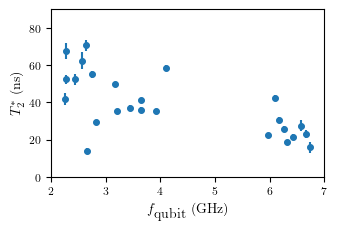

In [360]:
plt.figure(figsize=set_size(textwidth,0.5))
plt.scatter(qubit_freq,qubit_T2,s=10)
plt.errorbar(qubit_freq, qubit_T2, yerr=qubit_T2_error, fmt="o",markersize=4)

plt.ylim(0,90)
plt.xlim(2,7)
plt.ylabel('$T_{2}^{*}$ (ns)')
plt.xlabel(r'$f_{\textrm{qubit}}$ (GHz)')
plt.savefig(path+'\\T2_fullrange.pdf',dpi=200,bbox_inches='tight')

In [ ]:
path

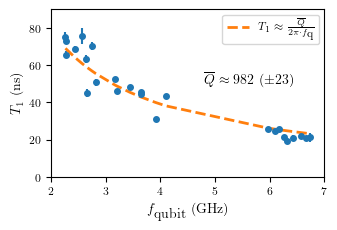

In [358]:
plt.figure(figsize=set_size(textwidth,0.5))
#plt.scatter(qubit_freq,qubit_T1,s=10)
plt.errorbar(qubit_freq, qubit_T1, yerr=qubit_T1_error, fmt="o",markersize=4)
plt.plot(np.sort(qubit_freq),Q_fit(np.array(np.sort(qubit_freq)),*popt),
         '--',linewidth=2,label=r'$T_{1} \approx \frac{\overline{Q}}{2\pi \cdot f_{\textrm{q}}}$')
plt.ylim(0,90)
plt.xlim(2,7)
plt.ylabel('$T_{1}$ (ns)')
plt.xlabel(r'$f_{\textrm{qubit}}$ (GHz)')
plt.legend()
plt.text(4.8,50,r'$\overline{Q} \approx 982\, \left(\pm 23\right) $',fontsize=10)
plt.savefig(path+'\\T1_fullrange_noitalic.pdf',dpi=200,bbox_inches='tight')

In [357]:
path

'L:/Oliver/Measurment/Resonator_measurement/20231010_Gatemon_RT_5nm_2'

# Purcell limit



In [194]:
kappa = 4.812/1.4 # in MHz
detuning = 0.34 # g/Delta
Tpurcell = (2*np.pi*kappa*(detuning**2))**-1

In [29]:
kappa = 3.495 # in MHz
detuning = 0.213/0.925# g/Delta
Tpurcell = (2*np.pi*kappa*(detuning**2))**-1
print(Tpurcell)

0.858810232223587


In [35]:
from scipy import constants

In [36]:
constants.epsilon_0

8.8541878128e-12

In [59]:
#Parallel plate capacitor
A = 450e-9*150e-9 
eps = 9.6
d= 10e-9 
Cg = eps*constants.epsilon_0*A/d


In [60]:
Cg*1e15

0.5737513702694399

In [71]:
Z0 = 50 #Ohm
omega = 2*np.pi*5e9
Cgatemon = 85e-15
Zl = (omega*Cgatemon)**-1

In [72]:
Zl

374.4822190397538

In [73]:
Tdrive = np.pi/(2*Z0*Zl*(omega**3)*(Cg**2))
Tdrive*1e6

8.21904922507501

In [74]:
# formula in burkhard simons thesis

In [75]:

R = 50 # 50 Ohm feedline


In [76]:
Tdrive =  4*Cgatemon/(R*(Cg**2)*(omega**2))

In [77]:
Tdrive*1e6

20.929636986980793

# Supplementary Fig.7 - Transmon Purcell

In [13]:
path = r'Al_Transmon/20230623_11170Transmon_Line2'
filename = r'Al_Transmon/20230623_11170Transmon_Line2/20230623_11170Transmon_Line2.db'
initialise_or_create_database_at(filename)

In [10]:
dataset = load_by_run_spec(captured_run_id=11)
data = _get_data_from_ds(dataset)
data =qc.dataset.plotting._complex_to_real_preparser(data,conversion='mag_and_phase')

Trying to mark a run completed that was already completed.


In [11]:
power = data[0][0]['data'].flatten()
freq= data[0][1]['data'].flatten()
polar_abs = data[0][2]['data'].flatten()
polar_phase = data[1][2]['data'].flatten()
data_reshaped =qc.dataset.data_export.reshape_2D_data(power,freq,polar_abs)
data_reshaped_2 =qc.dataset.data_export.reshape_2D_data(power,freq,polar_phase)

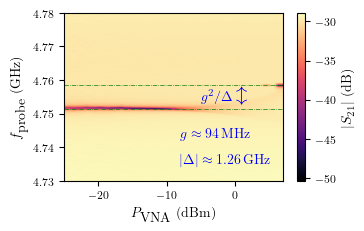

In [14]:
plt.figure(figsize=set_size(textwidth,0.5))
c=plt.imshow(20*np.log10(np.flipud(data_reshaped[2])),cmap='magma',interpolation ='hanning',interpolation_stage='rgba',extent =[data_reshaped[0][0], data_reshaped[0][-1],data_reshaped[1][0]/1e9,data_reshaped[1][-1]/1e9],aspect='auto')
plt.colorbar(label='$|S_{21}|$ (dB)')
plt.axhline(y=4.758534795, color='green', linestyle='-.', linewidth=0.5,label='Horizontal Line at y=0.5')
plt.axhline(y=4.751461543, color='green', linestyle='-.', linewidth=0.5,label='Horizontal Line at y=0.5')
plt.text(0, 4.754, r'$\leftrightarrow$', color='blue', fontsize=15,rotation='vertical')
plt.text(-5, 4.754, r'$g^{2}/\Delta$', color='blue', fontsize=10,rotation='horizontal')
plt.text(-8, 4.735, r'$|\Delta| \approx 1.26 \, \textrm{GHz}$', color='blue', fontsize=10,rotation='horizontal')
plt.text(-8, 4.743, r'$g \approx 94 \, \textrm{MHz}$', color='blue', fontsize=10,rotation='horizontal')
#plt.text(-24, 4.743, r'$\kappa \approx 2.23 \cdot 2\pi \, \textrm{MHz}$', color='blue', fontsize=10,rotation='horizontal')
plt.ylabel(r'$f_{\textrm{probe}}$ (GHz)')
plt.xlabel(r'$P_{\textrm{VNA}}$ (dBm)')
#plt.savefig(path+'\\id_11.pdf',dpi=450,bbox_inches='tight')

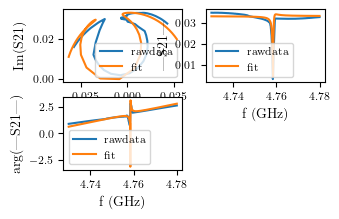

4758534795.592675


In [211]:
amp = data_reshaped[2][:,-1]
phase = data_reshaped_2[2][:,-1]
freq =data_reshaped[1]
response = amp*np.exp(1j*phase)
port1 = circuit.notch_port() 
port1.add_data(freq,response)
port1.do_calibration(freq,response)
port1.autofit()
port1.plotall()
fr = port1.fitresults['fr']
print(fr)

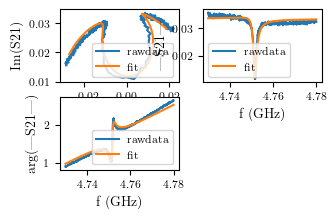

2.237432762320735


In [212]:
amp = data_reshaped[2][:,0]
phase = data_reshaped_2[2][:,0]
freq =data_reshaped[1]
response = amp*np.exp(1j*phase)
port1 = circuit.notch_port() 
port1.add_data(freq,response)
port1.do_calibration(freq,response)
port1.autofit()
port1.plotall()
fr2 = port1.fitresults['fr']
Ql = port1.fitresults['Ql']
kappa = fr2/Ql
print(kappa/1e6)